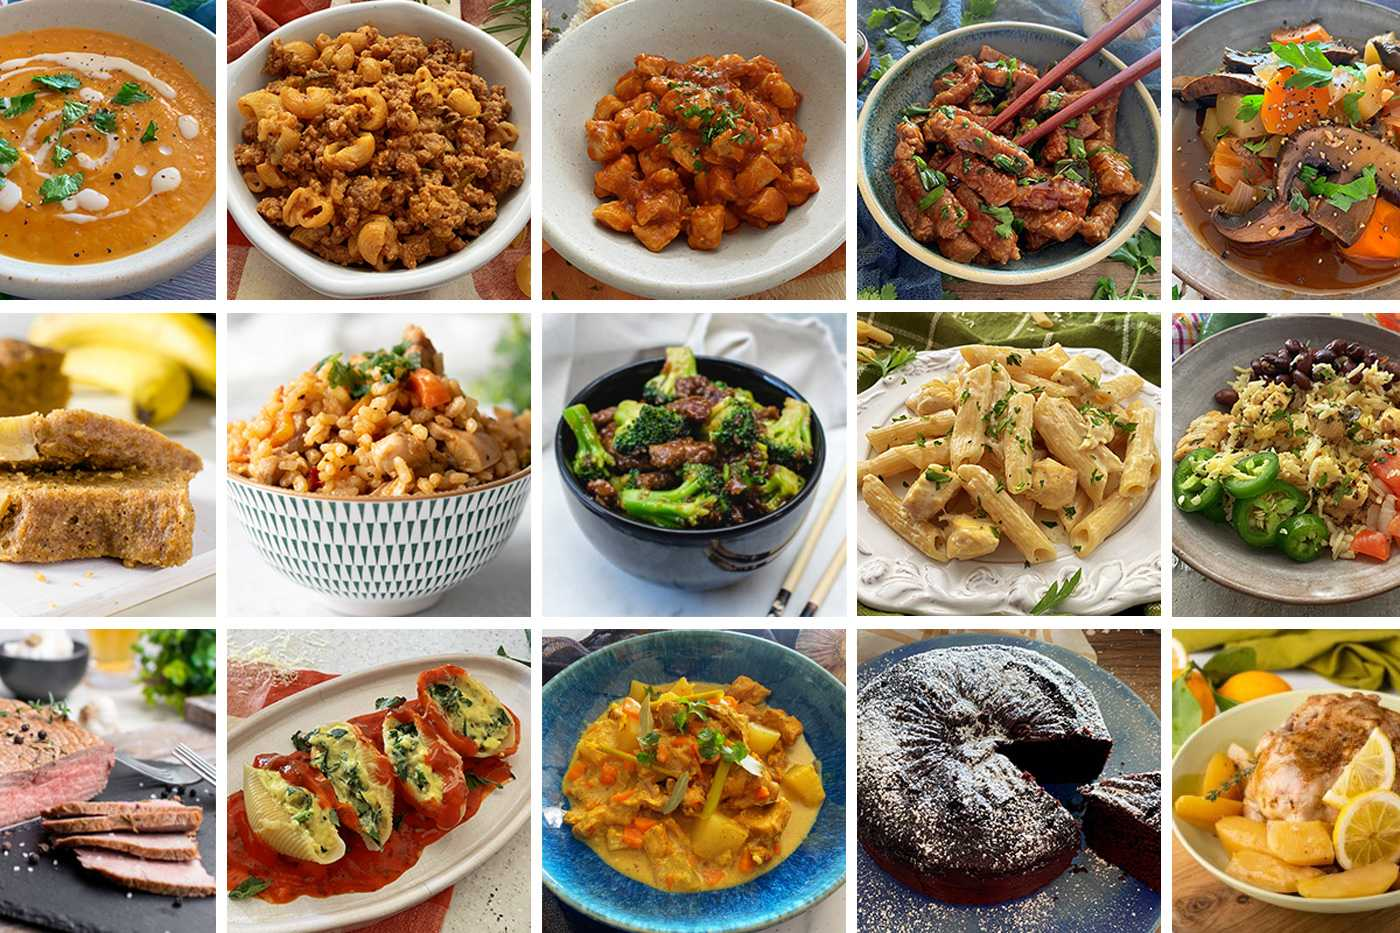

In [305]:
#show picture
from IPython.display import Image
Image(filename='Instant-Pot-Recipes.jpg')

# Objective: Increase site traffic by predicting recipe popularity

    - Create a written report to summarize the analysis you have performed and your findings.

        ● Data validation:
            ○ Describe validation and cleaning steps for every column in the data

        ● Exploratory Analysis to answer the customer questions ensuring you include:
            ○ Two different types of graphic showing single variables only
            ○ At least one graphic showing two or more variables
            ○ Description of your findings
        ● Model Development including:
            ○ What type of problem this is
            ○ Fitting a baseline model
            ○ Fitting a comparison model

        ● Model evaluation
            ○ Show how the two models compare

        ● Definition of a metric for the business to monitor
            ○ How should the business monitor what they want to achieve?
            ○ Estimate the initial value(s) for the metric based on the current data?
            
        ● Final summary including recommendations that the business should undertake
            - Prepare and deliver a presentation of max 10 slides to the product owner.

# Environment Setup

In [306]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats

#allow plots to appear directly in the notebook
%matplotlib inline
#show all columns in pandas
pd.set_option('display.max_columns', None)

In [307]:
#function to see percentage of missing values
def missing_values(df):
    missing = pd.DataFrame(df.isnull().sum())
    missing['%'] = round((missing[0]/len(df))*100, 2)
    missing.columns = ['Missing Values', '%']
    return missing.sort_values(by='Missing Values', ascending=False)

#function to plot disribution of all variables in a dataframe with dtype = int64 or float64
def plot_distributions(df):
    for col in df.columns:
        if df[col].dtype == 'int64' or df[col].dtype == 'float64':
            sns.distplot(df[col])
            plt.show()
            
#function to check for outliers in a dataframe with dtype = int64 or float64
def check_outliers(df):
    for col in df.columns:
        if df[col].dtype == 'int64' or df[col].dtype == 'float64':
            sns.boxplot(df[col])
            plt.show()
            
#function to remove outliers with iqr method 
def remove_outliers(df):
    for col in df.columns:
        if df[col].dtype == 'int64' or df[col].dtype == 'float64':
            q1 = df[col].quantile(0.25)
            q3 = df[col].quantile(0.75)
            iqr = q3 - q1
            lower = q1 - (1.5 * iqr)
            upper = q3 + (1.5 * iqr)
            df = df[(df[col] > lower) & (df[col] < upper)]
    return df

#function to remove outliers with z method and threshold of 3
def remove_outliers_z(df):
    for col in df.columns:
        if df[col].dtype == 'int64' or df[col].dtype == 'float64':
            z = np.abs(stats.zscore(df[col]))
            df = df[(z < 3)]
    return df

# Importing dataset

In [308]:
#import data
df = pd.read_csv('recipe_site_traffic_2212.csv')

## Checking the dataframe

In [309]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB


In [310]:
df.shape

(947, 8)

    The data is as follows:

    - Recipe: Has a unique identificator which is an integer64              0% of nulls
    - Calories: Float indicating number of calories                         5.5% of nulls
    - Carbohydrate: Float indicating amount of carbohydrates                5.5% of nulls
    - Sugar: Float indicating amount of sugar                               5.5% of nulls
    - Protein: Float indicating amount of proteins                          5.5% of nulls
    - Category: String with 10 categories of food                           0% of nulls
    - Servings: String indicating a number with no of people                0% of nulls
    - High Traffic: String indicating whether there is high traffic or not  0% of nulls

In [311]:
missing_values(df)

Missing Values      %
high_traffic             373  39.39
calories                  52   5.49
carbohydrate              52   5.49
sugar                     52   5.49
protein                   52   5.49
recipe                     0   0.00
category                   0   0.00
servings                   0   0.00

In [312]:
#checking head and tail of df to see if it conforms with what we have seen so far
df

recipe  calories  carbohydrate  sugar  protein      category servings  \
0         1       NaN           NaN    NaN      NaN          Pork        6   
1         2     35.48         38.56   0.66     0.92        Potato        4   
2         3    914.28         42.68   3.09     2.88     Breakfast        1   
3         4     97.03         30.56  38.63     0.02     Beverages        4   
4         5     27.05          1.85   0.80     0.53     Beverages        4   
..      ...       ...           ...    ...      ...           ...      ...   
942     943   1161.00          5.31  22.39    44.22  Lunch/Snacks        2   
943     944       NaN           NaN    NaN      NaN        Potato        2   
944     945    951.74         29.42   3.57    13.87          Pork        2   
945     946    266.61         35.77   0.97     8.07        Potato        6   
946     947    184.56         45.21   6.20     0.03     Beverages        4   

    high_traffic  
0           High  
1           High  
2            NaN  
3           High  
4            NaN  
..           ...  
942          NaN  
943         High  
944         High  
945         High  
946          NaN  

[947 rows x 8 columns]

In [313]:
#set index to recipe 
df.set_index('recipe', inplace=True)

# Data Preparation

    After having a sneak peak at the data, here is a to do list to make it ready to start with EDA, feature engineering and rest of pipeline

        - Check categories and dummify accordingly without duplicates
        - Check nulls and come up with an strategy 
        - Convert servings to an integer, no reason for a string to be there
        - Convert y objective variable to integer with 0 or 1 for low and high traffic
    

## Patching Up Servings feature

In [314]:
#show unique values for servings
df['servings'].unique()

array(['6', '4', '1', '2', '4 as a snack', '6 as a snack'], dtype=object)

In [315]:
#deleting " as a snack" from servings
df['servings'] = df['servings'].str.replace(' as a snack', '')

In [316]:
df['servings'].unique()

array(['6', '4', '1', '2'], dtype=object)

In [317]:
#convert servings to int
df['servings'] = df['servings'].astype(int)

## Checking target variable

In [318]:
df['high_traffic'].unique()

array(['High', nan], dtype=object)

In [319]:
#convert "High" to 1 and "nan" to 0, and set dtype as bool
df['high_traffic'] = df['high_traffic'].replace('High', 1)
df['high_traffic'] = df['high_traffic'].fillna(0)
df['high_traffic'] = df['high_traffic'].astype(int)

In [320]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 947 entries, 1 to 947
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   calories      895 non-null    float64
 1   carbohydrate  895 non-null    float64
 2   sugar         895 non-null    float64
 3   protein       895 non-null    float64
 4   category      947 non-null    object 
 5   servings      947 non-null    int64  
 6   high_traffic  947 non-null    int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 59.2+ KB


## Previsualization of df

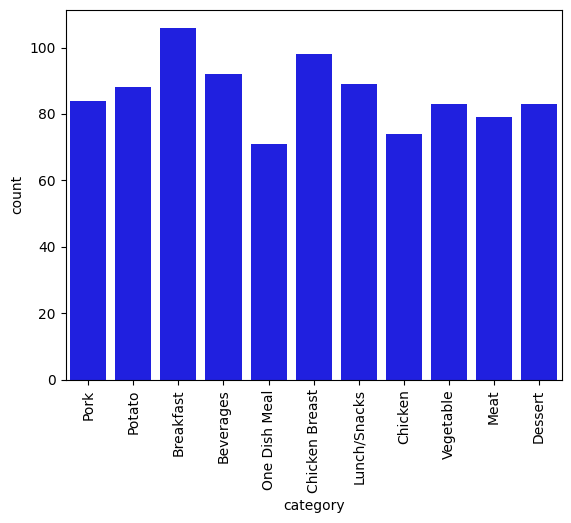

In [321]:
#barplot of df_nulls with x axis category and y axis number of nulls
sns.countplot(x='category', data=df, color= 'blue')
plt.xticks(rotation=90)
plt.show()

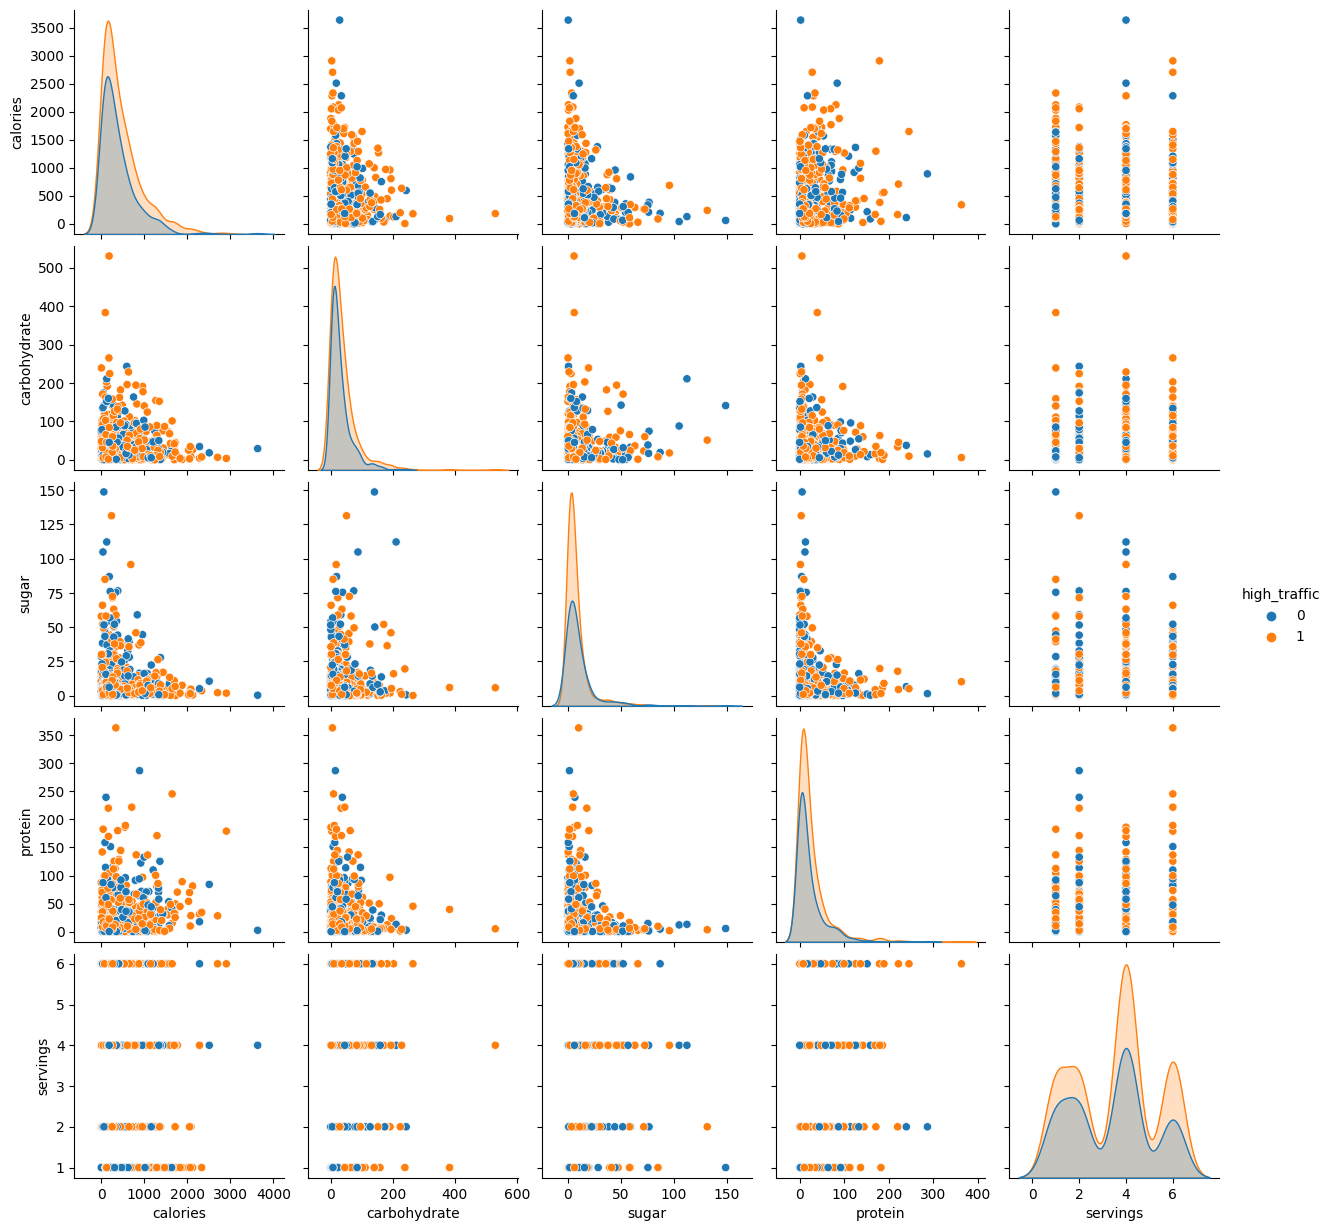

In [322]:
#seaborn pairplot of df
sns.pairplot(df, hue='high_traffic')
plt.show()


## Dealing with nulls

In [323]:
#show nulls in df
df.isnull().sum()
 

calories        52
carbohydrate    52
sugar           52
protein         52
category         0
servings         0
high_traffic     0
dtype: int64

In [324]:
#subset with rows with nulls
df_nulls = df[df.isnull().any(axis=1)]
df_nulls

calories  carbohydrate  sugar  protein        category  servings  \
recipe                                                                     
1            NaN           NaN    NaN      NaN            Pork         6   
24           NaN           NaN    NaN      NaN            Meat         2   
49           NaN           NaN    NaN      NaN  Chicken Breast         4   
83           NaN           NaN    NaN      NaN            Meat         4   
90           NaN           NaN    NaN      NaN            Pork         6   
117          NaN           NaN    NaN      NaN  Chicken Breast         6   
122          NaN           NaN    NaN      NaN         Dessert         2   
137          NaN           NaN    NaN      NaN   One Dish Meal         2   
150          NaN           NaN    NaN      NaN          Potato         2   
188          NaN           NaN    NaN      NaN            Pork         4   
210          NaN           NaN    NaN      NaN         Dessert         2   
213          NaN           NaN    NaN      NaN         Dessert         4   
222          NaN           NaN    NaN      NaN         Dessert         1   
250          NaN           NaN    NaN      NaN         Chicken         6   
263          NaN           NaN    NaN      NaN         Chicken         4   
279          NaN           NaN    NaN      NaN    Lunch/Snacks         4   
281          NaN           NaN    NaN      NaN            Meat         1   
298          NaN           NaN    NaN      NaN    Lunch/Snacks         6   
327          NaN           NaN    NaN      NaN          Potato         4   
352          NaN           NaN    NaN      NaN          Potato         4   
355          NaN           NaN    NaN      NaN            Pork         4   
373          NaN           NaN    NaN      NaN       Vegetable         2   
377          NaN           NaN    NaN      NaN            Pork         6   
389          NaN           NaN    NaN      NaN    Lunch/Snacks         4   
406          NaN           NaN    NaN      NaN       Vegetable         4   
428          NaN           NaN    NaN      NaN       Vegetable         4   
456          NaN           NaN    NaN      NaN            Pork         6   
531          NaN           NaN    NaN      NaN       Vegetable         1   
535          NaN           NaN    NaN      NaN         Chicken         2   
539          NaN           NaN    NaN      NaN       Vegetable         4   
546          NaN           NaN    NaN      NaN  Chicken Breast         6   
556          NaN           NaN    NaN      NaN            Meat         2   
574          NaN           NaN    NaN      NaN    Lunch/Snacks         4   
582          NaN           NaN    NaN      NaN         Chicken         1   
609          NaN           NaN    NaN      NaN  Chicken Breast         4   
675          NaN           NaN    NaN      NaN            Pork         4   
684          NaN           NaN    NaN      NaN          Potato         1   
712          NaN           NaN    NaN      NaN    Lunch/Snacks         4   
713          NaN           NaN    NaN      NaN            Pork         6   
750          NaN           NaN    NaN      NaN         Dessert         4   
766          NaN           NaN    NaN      NaN            Pork         1   
773          NaN           NaN    NaN      NaN   One Dish Meal         4   
852          NaN           NaN    NaN      NaN    Lunch/Snacks         4   
860          NaN           NaN    NaN      NaN   One Dish Meal         4   
866          NaN           NaN    NaN      NaN    Lunch/Snacks         6   
891          NaN           NaN    NaN      NaN            Meat         4   
894          NaN           NaN    NaN      NaN   One Dish Meal         4   
897          NaN           NaN    NaN      NaN         Chicken         6   
912          NaN           NaN    NaN      NaN         Dessert         6   
919          NaN           NaN    NaN      NaN            Pork         6   
939          NaN           NaN    NaN      NaN          

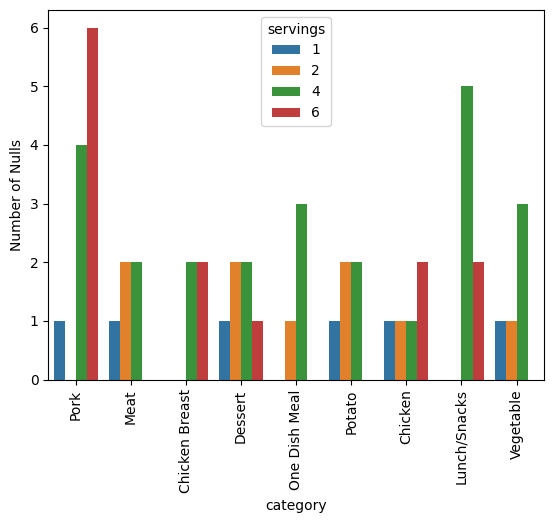

In [325]:
#barplot of df_nulls with x axis category and y axis number of nulls

sns.countplot(x='category', data=df_nulls, hue='servings')
plt.xticks(rotation=90)
#y tick title
plt.ylabel('Number of Nulls')
plt.show()


There appear to be many categories overlapping itself and some names are misleading, we will take care of that later

In [326]:
#for each category in category column, show mean, std, min, max, and quartiles for calories, carbohydrate, sugar and protein
for category in df['category'].unique():
    print(category)
    print(df[df['category'] == category][['calories', 'carbohydrate', 'sugar', 'protein']].describe())
    print('\n')

Pork
          calories  carbohydrate      sugar     protein
count    73.000000     73.000000  73.000000   73.000000
mean    629.708082     28.076164   8.040137   43.797671
std     624.531554     25.668843   9.293900   46.481453
min       1.560000      0.470000   0.080000    1.320000
25%     144.280000      7.520000   1.890000   13.870000
50%     399.260000     19.560000   5.230000   29.820000
75%     951.740000     42.530000   9.400000   52.000000
max    2906.010000    111.080000  49.530000  189.330000


Potato
          calories  carbohydrate      sugar    protein
count    83.000000     83.000000  83.000000  83.000000
mean    425.068554     58.150361   3.718916   8.574217
std     374.508334     80.949176   3.256371   9.347805
min       9.260000      0.050000   0.010000   0.000000
25%     139.645000     16.315000   1.225000   2.960000
50%     269.460000     32.540000   2.640000   5.900000
75%     611.000000     61.805000   5.250000   9.685000
max    2068.070000    530.420000  13.44000

## Inputting nulls with median
It appears to be a big difference between the min and the max for each of the categories so the strategy in this case is to input the df with the median instead of mean as it is more robust to outliers and can preserve better the data distribution

In [327]:
#input median values for nans in df for calories, carbohydrate, sugar and protein
df['calories'] = df['calories'].fillna(df['calories'].median())
df['carbohydrate'] = df['carbohydrate'].fillna(df['carbohydrate'].median())
df['sugar'] = df['sugar'].fillna(df['sugar'].median())
df['protein'] = df['protein'].fillna(df['protein'].median())

#show percentage of nulls in df
missing_values(df) 

Missing Values    %
calories                   0  0.0
carbohydrate               0  0.0
sugar                      0  0.0
protein                    0  0.0
category                   0  0.0
servings                   0  0.0
high_traffic               0  0.0

# EDA of df before data wrangling

/tmp/ipykernel_7388/2609660079.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col])


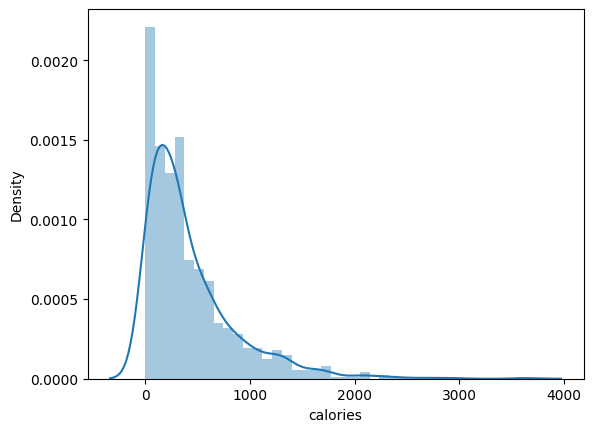

/tmp/ipykernel_7388/2609660079.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col])


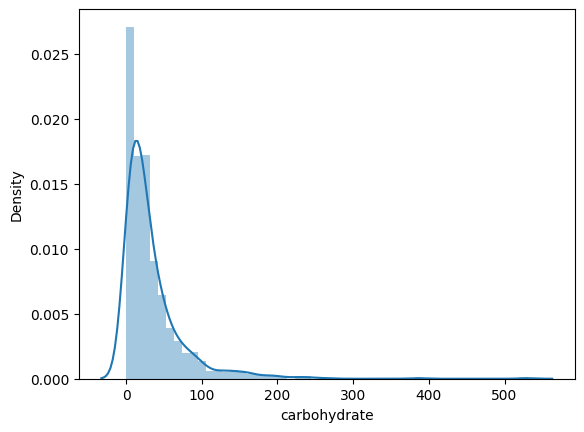

/tmp/ipykernel_7388/2609660079.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col])


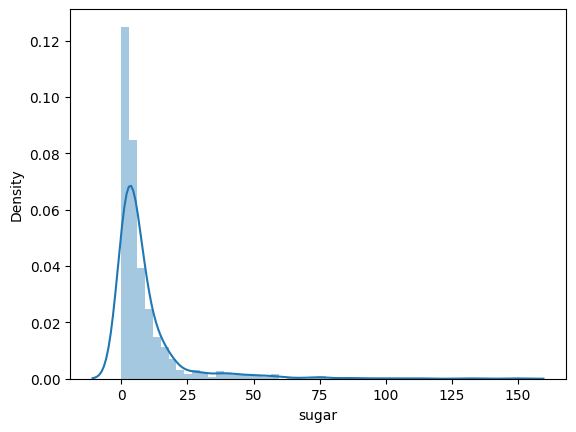

/tmp/ipykernel_7388/2609660079.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col])


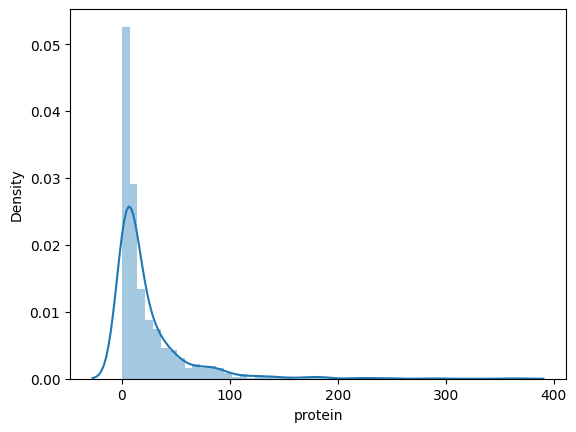

/tmp/ipykernel_7388/2609660079.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col])


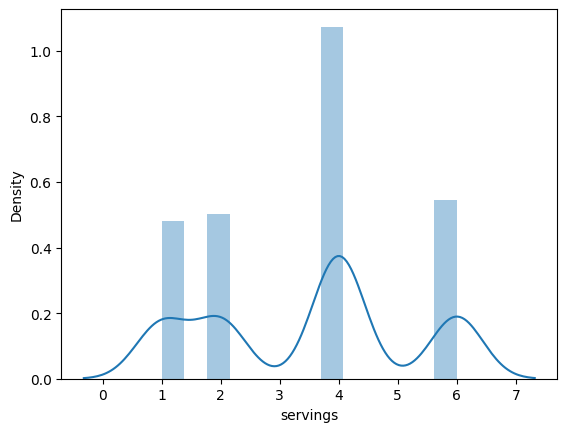

/tmp/ipykernel_7388/2609660079.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col])


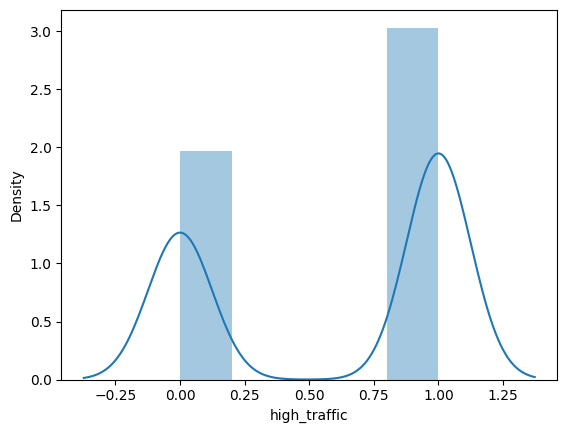

In [328]:
plot_distributions(df)

All distributions are skewed to the left, we will have to think of something later

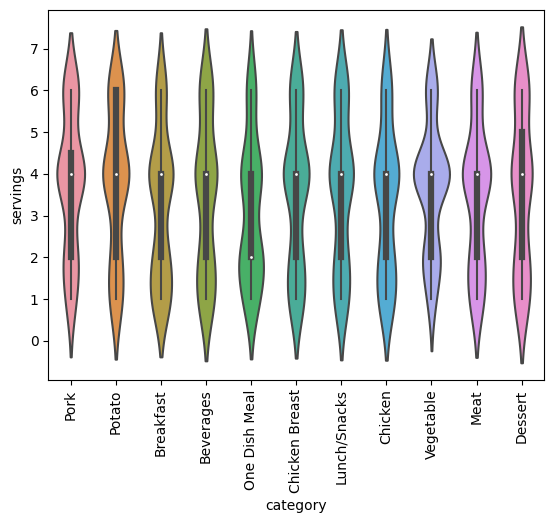

In [329]:
#show seaborn violinplot of servings and calories by category
sns.violinplot(x='category', y='servings', data=df)
plt.xticks(rotation=90)
plt.show()
 


<Figure size 3000x1500 with 0 Axes>

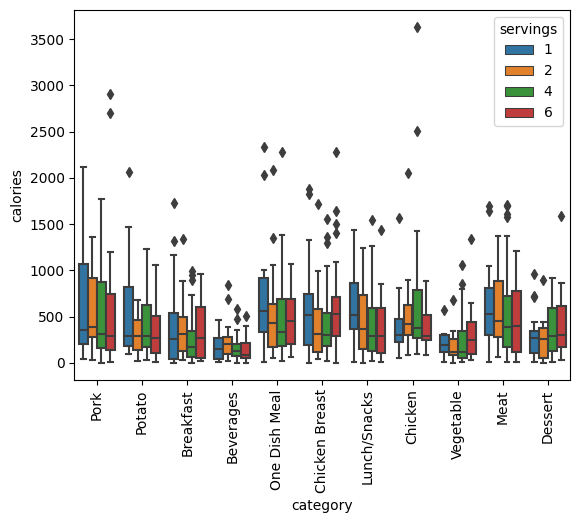

<Figure size 3000x1500 with 0 Axes>

In [330]:
#boxplot of calories and servings by category
sns.boxplot(x='category', y='calories', data=df, hue='servings')
plt.xticks(rotation=90)
#size of plot
plt.figure(figsize=(30,15))


## Boolean as number variables

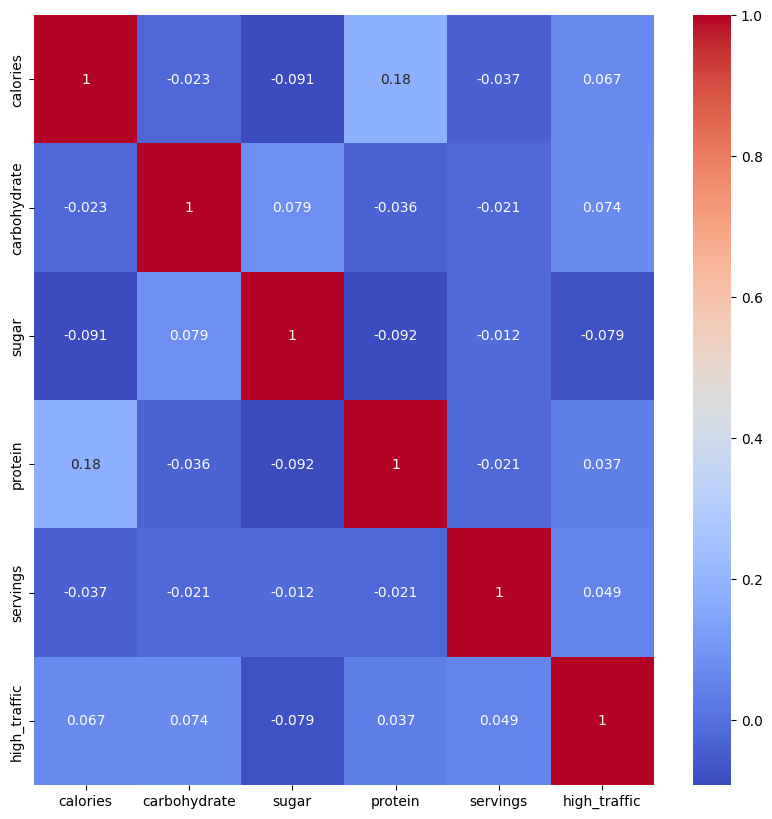

In [331]:
#correlation heatmap of df except category column
plt.figure(figsize=(10,10))
sns.heatmap(df.drop('category', axis=1).corr(), annot=True, cmap='coolwarm')
plt.show()
 



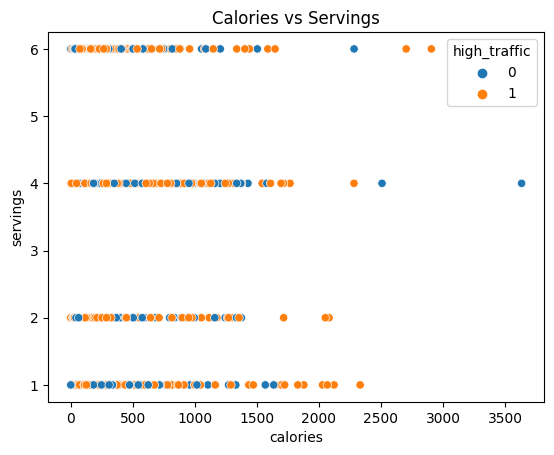

In [332]:
#scatterplot of calories and servings against high_traffic
plt.title('Calories vs Servings')
sns.scatterplot(x='calories', y='servings', data=df, hue='high_traffic')
plt.show()
 

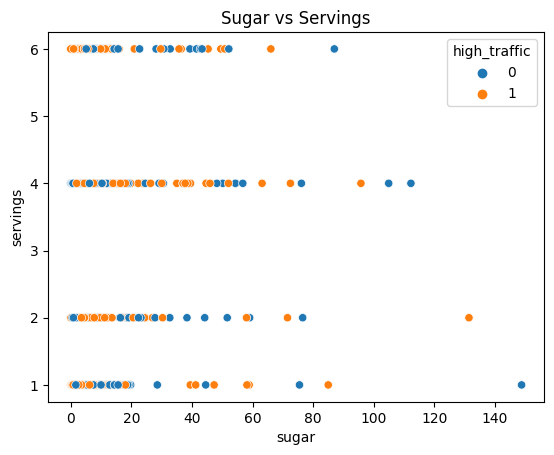

In [333]:
#scatterplot of sugar and servings against high_traffic
#title
plt.title('Sugar vs Servings')
sns.scatterplot(x='sugar', y='servings', data=df, hue='high_traffic')
plt.show()


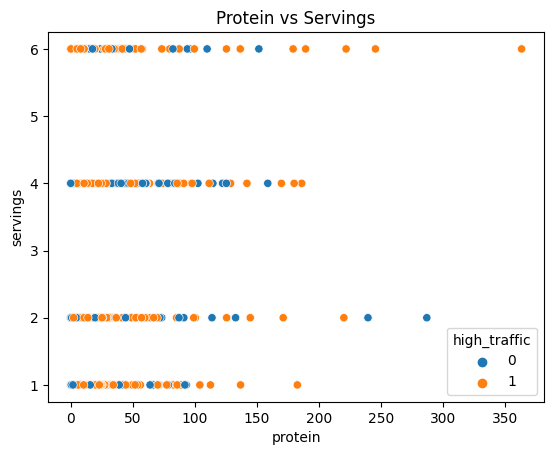

In [334]:
#scatterplot of protein and servings against high_traffic
plt.title('Protein vs Servings')
sns.scatterplot(x='protein', y='servings', data=df, hue='high_traffic')
plt.show()


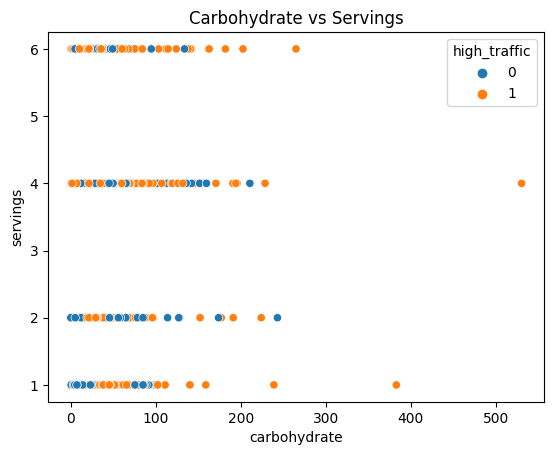

In [335]:
#scatterplot of carbohydrate and servings against high_traffic
plt.title('Carbohydrate vs Servings')
sns.scatterplot(x='carbohydrate', y='servings', data=df, hue='high_traffic')
plt.show()

# Data Wrangling

## Renaming and merging of categorical variables
Now let's handle the different categories

In [336]:
#distinct values in category column
df['category'].unique()

array(['Pork', 'Potato', 'Breakfast', 'Beverages', 'One Dish Meal',
       'Chicken Breast', 'Lunch/Snacks', 'Chicken', 'Vegetable', 'Meat',
       'Dessert'], dtype=object)

In [337]:
#merge Chicken Breast and Chicken into Chicken
df['category'] = df['category'].replace('Chicken Breast', 'Chicken')
df['category'] = df['category'].replace('Chicken', 'Chicken')
df['category'].unique()



array(['Pork', 'Potato', 'Breakfast', 'Beverages', 'One Dish Meal',
       'Chicken', 'Lunch/Snacks', 'Vegetable', 'Meat', 'Dessert'],
      dtype=object)

    - Chicken and Chicken Breast certainly do not add value separately.
    - Potato is part of the family Vegetables but from a cuisine perspective is not clear whether these are recipes wich its main ingredient its the potato or if rather Vegetables, more vegetables than potato are being used
    - For Meat, we could put Pork and Chicken under this category but it seems that this could potentially be Red Meat as in a beef steak, to avoid uncertainty this will be renamed
    - Lunch/ Snacks is quite confusing, if it is lunch it is certainly not a snack, given the amount of servings and calories I am renaming this to lunch only

In [338]:
#rename Meat to Red Meat
df['category'] = df['category'].replace('Meat', 'Red Meat')


In [339]:
#rename Lunch/Snacks to Lunch
df['category'] = df['category'].replace('Lunch/Snacks', 'Lunch')
df['category'].unique()

array(['Pork', 'Potato', 'Breakfast', 'Beverages', 'One Dish Meal',
       'Chicken', 'Lunch', 'Vegetable', 'Red Meat', 'Dessert'],
      dtype=object)

## Checking for outliers

In [340]:
df.shape

(947, 7)

Let's do a random investigation to see where the outliers are

    It looks like these outliers must be discriminated by the servings and the category they represent, we will do this manually

In [341]:
df.columns

Index(['calories', 'carbohydrate', 'sugar', 'protein', 'category', 'servings',
       'high_traffic'],
      dtype='object')

<Figure size 3000x1500 with 0 Axes>

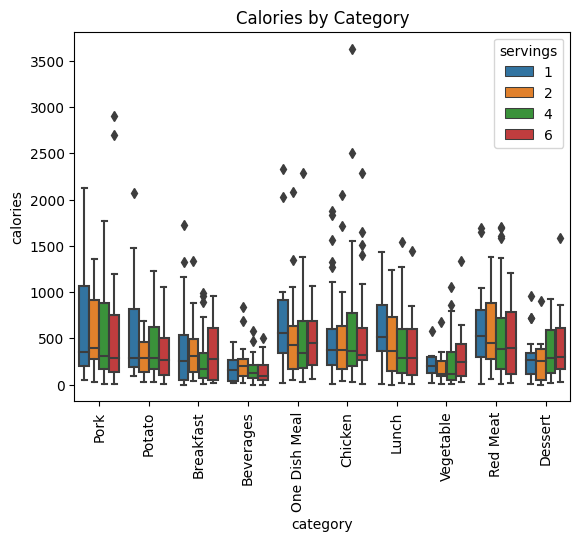

<Figure size 3000x1500 with 0 Axes>

In [342]:
#boxplot of calories and servings by category
plt.title('Calories by Category')
sns.boxplot(x='category', y='calories', data=df, hue='servings')
plt.xticks(rotation=90)
#size of plot
plt.figure(figsize=(30,15))
#title



## Selective outlier removal

In [343]:
#for category "Pork" and serings = 6, delete calories > 2500
df = df[~((df['category'] == 'Pork') & (df['servings'] == 6) & (df['calories'] > 2500))]
 
#for category "Potato" and servings = 1 delete calories > 1500
df = df[~((df['category'] == 'Potato') & (df['servings'] == 1) & (df['calories'] > 1500))]

#for category "Breakfast" and servings = 1 or 2 delete calories > 1200
df = df[~((df['category'] == 'Breakfast') & ((df['servings'] == 1) | (df['servings'] == 2)) & (df['calories'] > 1200))]

#for category "Breakfast" and servings = 3 delete calories > 700
df = df[~((df['category'] == 'Breakfast') & (df['servings'] == 3) & (df['calories'] > 700))]

#for category "Beverages" and all servings delete calories > 450
df = df[~((df['category'] == 'Beverages') & (df['calories'] > 450))]

#for category "One Dish Meal" and all servings delete calories > 1400
df = df[~((df['category'] == 'One Dish Meal') & (df['calories'] > 1400))]

#for category "Chicken Breast" and all servings delete calories > 1350
df = df[~((df['category'] == 'Chicken Breast') & (df['calories'] > 1350))]

#for category "Lunch/Snacks" and servings = 3 or 4 delete calories > 1350
df = df[~((df['category'] == 'Lunch/Snacks') & ((df['servings'] == 3) | (df['servings'] == 4)) & (df['calories'] > 1350))]

#for category "Chicken" and all servings delete calories > 1400
df = df[~((df['category'] == 'Chicken') & (df['calories'] > 1400))]

#for category "Vegetable" and servings = 1 or 2 delete calories > 500
df = df[~((df['category'] == 'Vegetable') & ((df['servings'] == 1) | (df['servings'] == 2)) & (df['calories'] > 500))]

#for category "Vegetable" and servings = 3 or 4 delete calories > 750
df = df[~((df['category'] == 'Vegetable') & ((df['servings'] == 3) | (df['servings'] == 4)) & (df['calories'] > 750))]

#for category "Meat" and all servings delete calories > 1400
df = df[~((df['category'] == 'Meat') & (df['calories'] > 1400))]

#for category "Desert" and servings = 1 or 2 delete calories > 500
df = df[~((df['category'] == 'Desert') & ((df['servings'] == 1) | (df['servings'] == 2)) & (df['calories'] > 500))]

#for category "Desert" and servings = 3 or 4 delete calories > 1200
df = df[~((df['category'] == 'Desert') & ((df['servings'] == 3) | (df['servings'] == 4)) & (df['calories'] > 1200))]





In [344]:
df.shape

(913, 7)

<Figure size 3000x1500 with 0 Axes>

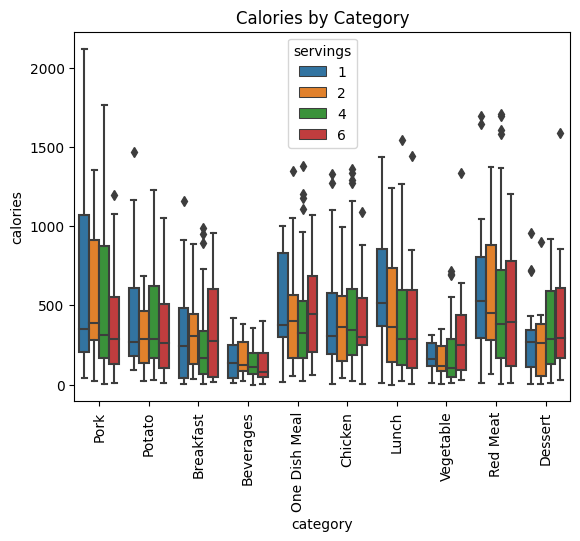

<Figure size 3000x1500 with 0 Axes>

In [345]:
#boxplot of calories and servings by category
plt.title('Calories by Category')
sns.boxplot(x='category', y='calories', data=df, hue='servings')
plt.xticks(rotation=90)
#size of plot
plt.figure(figsize=(30,15))
#title

<Figure size 3000x1500 with 0 Axes>

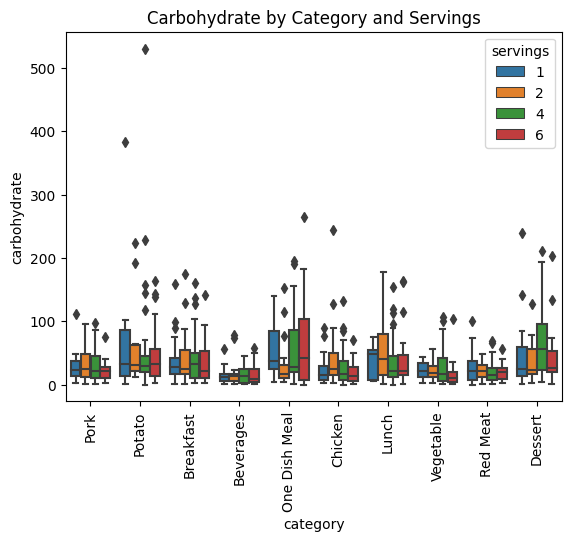

<Figure size 3000x1500 with 0 Axes>

In [346]:
#boxplot of carbohydrate and servings by category
plt.title('Carbohydrate by Category and Servings')
sns.boxplot(x='category', y='carbohydrate', data=df, hue='servings')
plt.xticks(rotation=90)
#size of plot
plt.figure(figsize=(30,15))


In [347]:
#for all categories and servings, remove carbohydrate > 200
df = df[~(df['carbohydrate'] > 190)]

In [348]:
df.shape

(900, 7)

<Figure size 3000x1500 with 0 Axes>

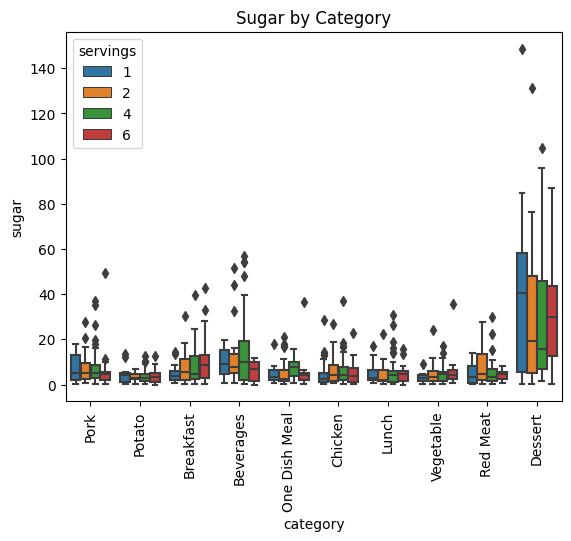

<Figure size 3000x1500 with 0 Axes>

In [349]:
#boxplot of sugar and servings by category
plt.title('Sugar by Category')
sns.boxplot(x='category', y='sugar', data=df, hue='servings')
plt.xticks(rotation=90)
#size of plot
plt.figure(figsize=(30,15))


In [350]:
# for categories Pork, Breakfast remove sugar > 25
#df = df[~((df['category'] == 'Pork') | (df['category'] == 'Breakfast')) & (df['sugar'] > 25)]

# for category Beverages remove sugar > 40
#df = df[~((df['category'] == 'Beverages') & (df['sugar'] > 40))]

# for category One Dish Meal, Chicken Breast, Lunch/Snacks, Chicken, and Vegetable remove sugar > 22
#df = df[~((df['category'] == 'One Dish Meal') | (df['category'] == 'Chicken Breast') | (df['category'] == 'Lunch/Snacks') | (df['category'] == 'Chicken') | (df['category'] == 'Vegetable')) & (df['sugar'] > 22)]

# for category Desert remove sugar > 95
df = df[~((df['category'] == 'Desert') & (df['sugar'] > 100))]



In [351]:
df.shape

(900, 7)

<Figure size 3000x1500 with 0 Axes>

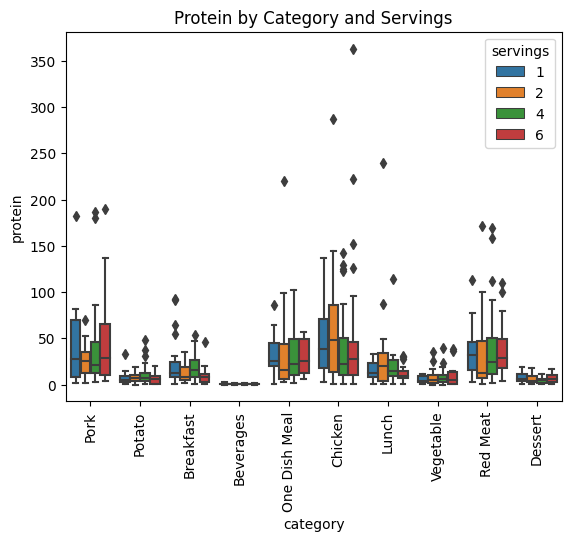

<Figure size 3000x1500 with 0 Axes>

In [352]:
#boxplot of protein and servings by category
plt.title('Protein by Category and Servings')
sns.boxplot(x='category', y='protein', data=df, hue='servings')
plt.xticks(rotation=90)
#size of plot
plt.figure(figsize=(30,15))
 
  

In [353]:
#for all categories and servings, remove protein > 150
df = df[~(df['protein'] > 150)]


In [354]:
df.shape

(887, 7)

/tmp/ipykernel_7388/2609660079.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col])


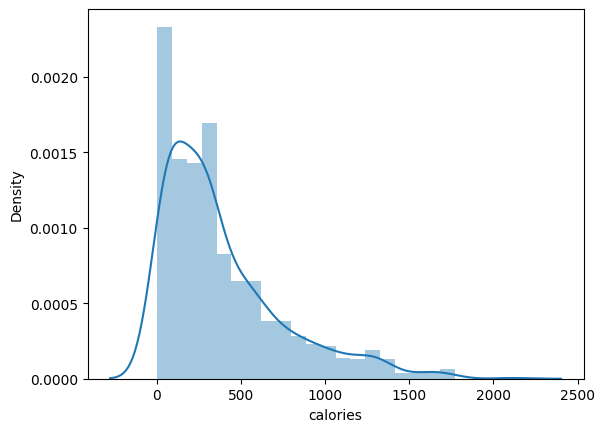

/tmp/ipykernel_7388/2609660079.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col])


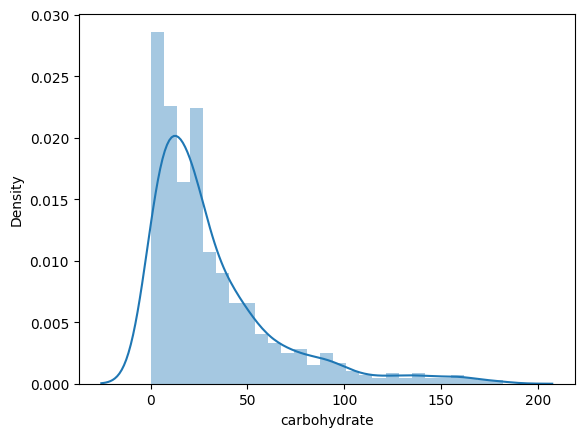

/tmp/ipykernel_7388/2609660079.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col])


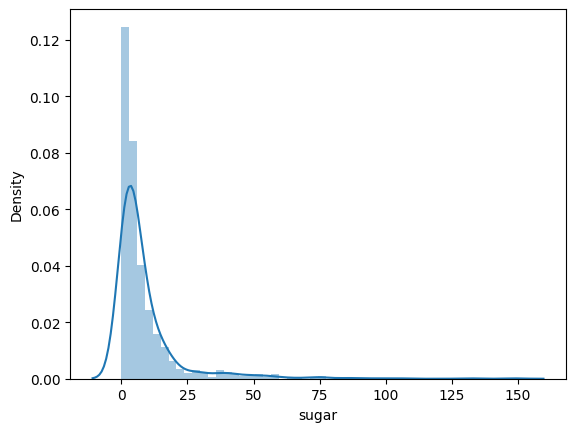

/tmp/ipykernel_7388/2609660079.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col])


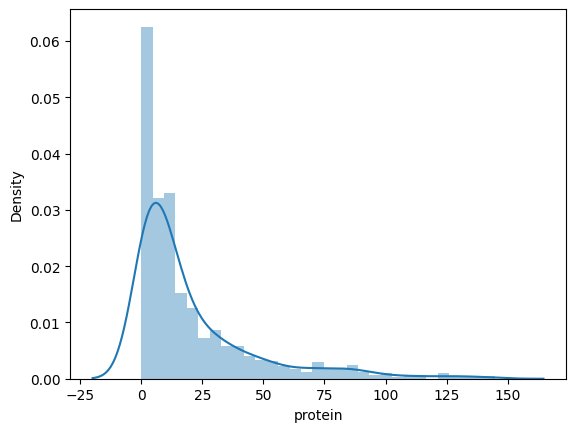

/tmp/ipykernel_7388/2609660079.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col])


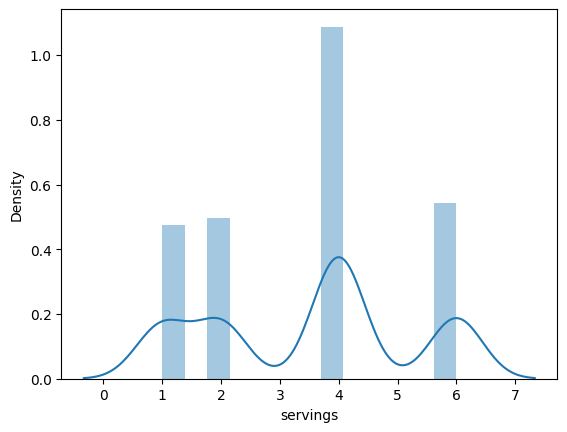

/tmp/ipykernel_7388/2609660079.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col])


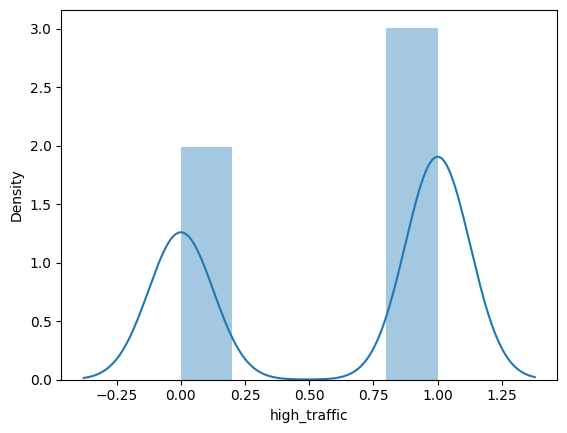

In [355]:
plot_distributions(df)

## Checking for correlation

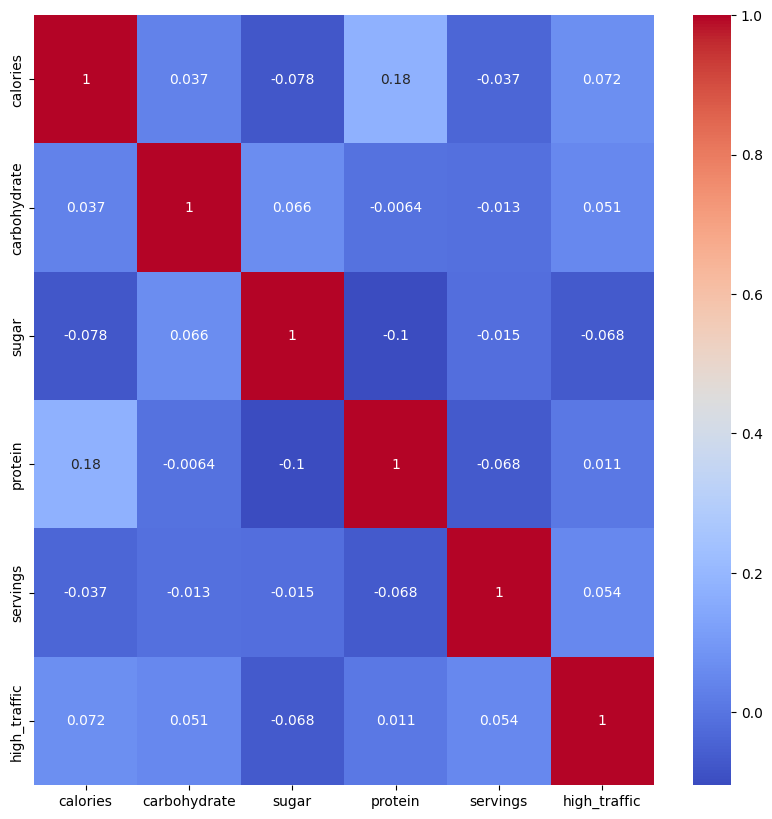

In [356]:
#correration heatmap of df except category column agains high_traffic
plt.figure(figsize=(10,10))
sns.heatmap(df.drop('category', axis=1).corr(), annot=True, cmap='coolwarm')
plt.show()
 
  


    Still, there is no clear correlation between variables

## Dummification

In [357]:
#Dummies for category column
df = pd.get_dummies(df, columns=['category'], drop_first=False, prefix='category')
df.head()

calories  carbohydrate  sugar  protein  servings  high_traffic  \
recipe                                                                   
1         288.55         21.48   4.55    10.80         6             1   
2          35.48         38.56   0.66     0.92         4             1   
3         914.28         42.68   3.09     2.88         1             0   
4          97.03         30.56  38.63     0.02         4             1   
5          27.05          1.85   0.80     0.53         4             0   

        category_Beverages  category_Breakfast  category_Chicken  \
recipe                                                             
1                    False               False             False   
2                    False               False             False   
3                    False                True             False   
4                     True               False             False   
5                     True               False             False   

        category_Dessert  category_Lunch  category_One Dish Meal  \
recipe                                                             
1                  False           False                   False   
2                  False           False                   False   
3                  False           False                   False   
4                  False           False                   False   
5                  False           False                   False   

        category_Pork  category_Potato  category_Red Meat  category_Vegetable  
recipe                                                                         
1                True            False              False               False  
2               False             True              False               False  
3               False            False              False               False  
4               False            False              False               False  
5               False            False              False               False

In [358]:
#position high_traffic column as last column
df = df[[col for col in df if col not in ['high_traffic']] + ['high_traffic']]
df.head()

calories  carbohydrate  sugar  protein  servings  category_Beverages  \
recipe                                                                         
1         288.55         21.48   4.55    10.80         6               False   
2          35.48         38.56   0.66     0.92         4               False   
3         914.28         42.68   3.09     2.88         1               False   
4          97.03         30.56  38.63     0.02         4                True   
5          27.05          1.85   0.80     0.53         4                True   

        category_Breakfast  category_Chicken  category_Dessert  \
recipe                                                           
1                    False             False             False   
2                    False             False             False   
3                     True             False             False   
4                    False             False             False   
5                    False             False             False   

        category_Lunch  category_One Dish Meal  category_Pork  \
recipe                                                          
1                False                   False           True   
2                False                   False          False   
3                False                   False          False   
4                False                   False          False   
5                False                   False          False   

        category_Potato  category_Red Meat  category_Vegetable  high_traffic  
recipe                                                                        
1                 False              False               False             1  
2                  True              False               False             1  
3                 False              False               False             0  
4                 False              False               False             1  
5                 False              False               False             0

In [359]:
df.dtypes

calories                  float64
carbohydrate              float64
sugar                     float64
protein                   float64
servings                    int64
category_Beverages           bool
category_Breakfast           bool
category_Chicken             bool
category_Dessert             bool
category_Lunch               bool
category_One Dish Meal       bool
category_Pork                bool
category_Potato              bool
category_Red Meat            bool
category_Vegetable           bool
high_traffic                int64
dtype: object

In [360]:
#pass all boolean dtype columns to int
for col in df.columns:
    if df[col].dtype == bool:
        df[col] = df[col].astype(int)
        
        

In [361]:
#rename high_traffic column to popularity
df = df.rename(columns={'high_traffic': 'popularity'})

In [362]:
#pandas eda of df
df.describe()
 

calories  carbohydrate       sugar     protein    servings  \
count   887.000000    887.000000  887.000000  887.000000  887.000000   
mean    385.252796     31.781973    8.787227   20.303608    3.488162   
std     361.415337     32.973025   14.113557   25.761100    1.726708   
min       0.140000      0.030000    0.010000    0.000000    1.000000   
25%     111.660000      9.345000    1.805000    3.440000    2.000000   
50%     288.550000     21.480000    4.550000   10.800000    4.000000   
75%     538.995000     41.805000    9.395000   26.070000    4.000000   
max    2122.240000    181.980000  148.750000  144.710000    6.000000   

       category_Beverages  category_Breakfast  category_Chicken  \
count          887.000000          887.000000        887.000000   
mean             0.096956            0.116122          0.173619   
std              0.296065            0.320552          0.378995   
min              0.000000            0.000000          0.000000   
25%              0.000000            0.000000          0.000000   
50%              0.000000            0.000000          0.000000   
75%              0.000000            0.000000          0.000000   
max              1.000000            1.000000          1.000000   

       category_Dessert  category_Lunch  category_One Dish Meal  \
count        887.000000      887.000000              887.000000   
mean           0.089064        0.099211                0.071026   
std            0.284997        0.299114                0.257013   
min            0.000000        0.000000                0.000000   
25%            0.000000        0.000000                0.000000   
50%            0.000000        0.000000                0.000000   
75%            0.000000        0.000000                0.000000   
max            1.000000        1.000000                1.000000   

       category_Pork  category_Potato  category_Red Meat  category_Vegetable  \
count     887.000000       887.000000         887.000000          887.000000   
mean        0.087937         0.092446           0.085682            0.087937   
std         0.283363         0.289819           0.280052            0.283363   
min         0.000000         0.000000           0.000000            0.000000   
25%         0.000000         0.000000           0.000000            0.000000   
50%         0.000000         0.000000           0.000000            0.000000   
75%         0.000000         0.000000           0.000000            0.000000   
max         1.000000         1.000000           1.000000            1.000000   

       popularity  
count  887.000000  
mean     0.602029  
std      0.489755  
min      0.000000  
25%      0.000000  
50%      1.000000  
75%      1.000000  
max      1.000000

# Feature Engineering

In [363]:
df.shape

(887, 16)

In [364]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 887 entries, 1 to 947
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   calories                887 non-null    float64
 1   carbohydrate            887 non-null    float64
 2   sugar                   887 non-null    float64
 3   protein                 887 non-null    float64
 4   servings                887 non-null    int64  
 5   category_Beverages      887 non-null    int64  
 6   category_Breakfast      887 non-null    int64  
 7   category_Chicken        887 non-null    int64  
 8   category_Dessert        887 non-null    int64  
 9   category_Lunch          887 non-null    int64  
 10  category_One Dish Meal  887 non-null    int64  
 11  category_Pork           887 non-null    int64  
 12  category_Potato         887 non-null    int64  
 13  category_Red Meat       887 non-null    int64  
 14  category_Vegetable      887 non-null    int64  

In [365]:
#perform a yeo-johnson transformation on calories, carbohydrate, sugar and protein to make them more normally distributed
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer()
df[['calories', 'carbohydrate', 'sugar', 'protein']] = pt.fit_transform(df[['calories', 'carbohydrate', 'sugar', 'protein']])
df.head()


calories  carbohydrate     sugar   protein  servings  \
recipe                                                         
1       0.056613      0.028481  0.053689  0.041637         6   
2      -1.418210      0.594509 -1.418608 -1.375496         4   
3       1.343435      0.698965 -0.285469 -0.840193         1   
4      -0.822332      0.362249  1.801352 -1.842467         4   
5      -1.550215     -1.663283 -1.308219 -1.544664         4   

        category_Beverages  category_Breakfast  category_Chicken  \
recipe                                                             
1                        0                   0                 0   
2                        0                   0                 0   
3                        0                   1                 0   
4                        1                   0                 0   
5                        1                   0                 0   

        category_Dessert  category_Lunch  category_One Dish Meal  \
recipe                                                             
1                      0               0                       0   
2                      0               0                       0   
3                      0               0                       0   
4                      0               0                       0   
5                      0               0                       0   

        category_Pork  category_Potato  category_Red Meat  category_Vegetable  \
recipe                                                                          
1                   1                0                  0                   0   
2                   0                1                  0                   0   
3                   0                0                  0                   0   
4                   0                0                  0                   0   
5                   0                0                  0                   0   

        popularity  
recipe              
1                1  
2                1  
3                0  
4                1  
5                0

/tmp/ipykernel_7388/2609660079.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col])


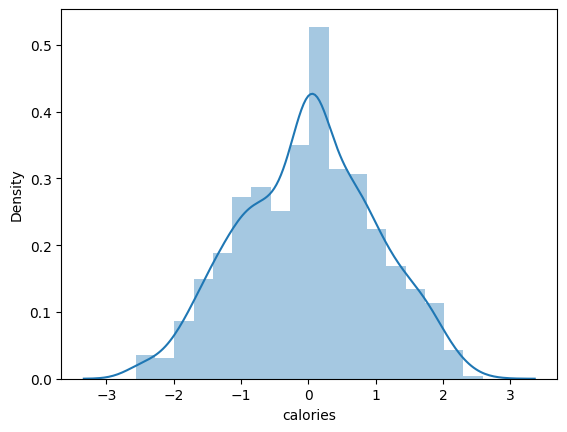

/tmp/ipykernel_7388/2609660079.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col])


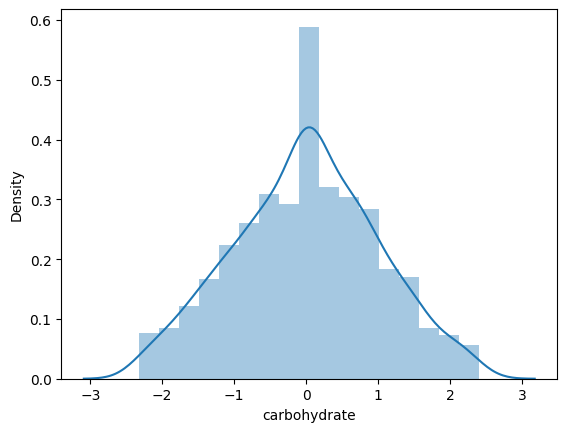

/tmp/ipykernel_7388/2609660079.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col])


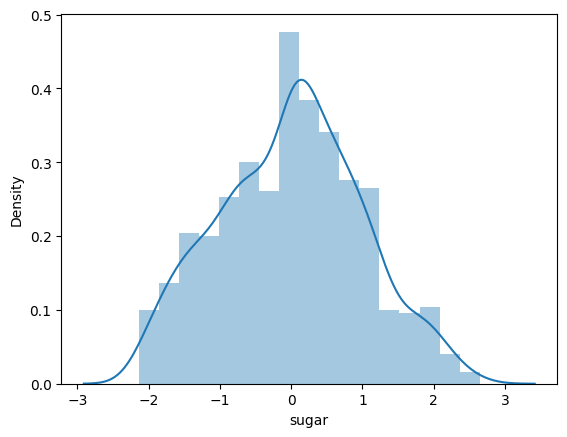

/tmp/ipykernel_7388/2609660079.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col])


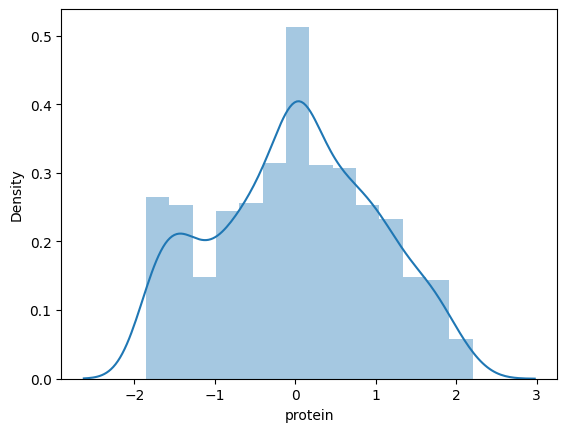

/tmp/ipykernel_7388/2609660079.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col])


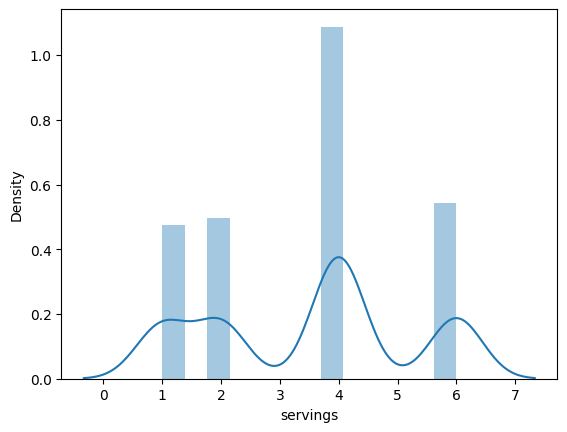

/tmp/ipykernel_7388/2609660079.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col])


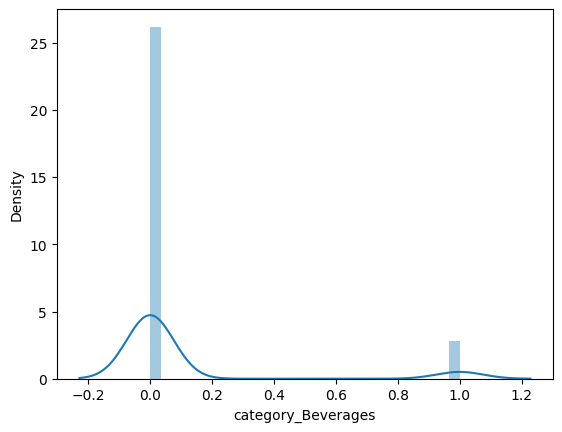

/tmp/ipykernel_7388/2609660079.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col])


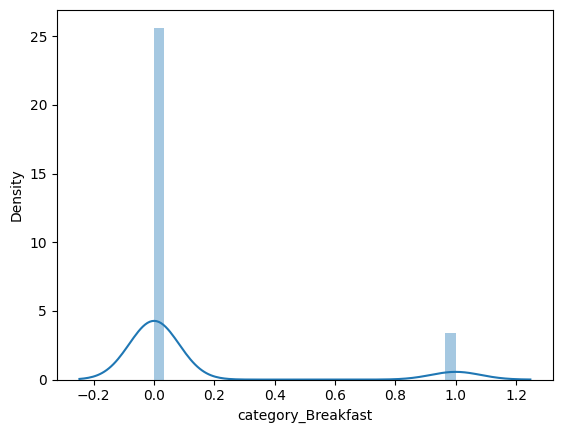

/tmp/ipykernel_7388/2609660079.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col])


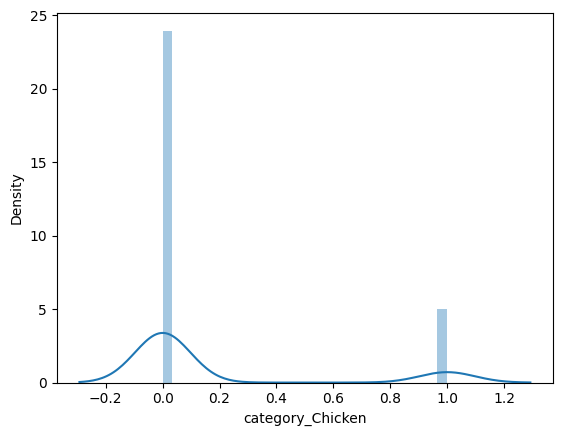

/tmp/ipykernel_7388/2609660079.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col])


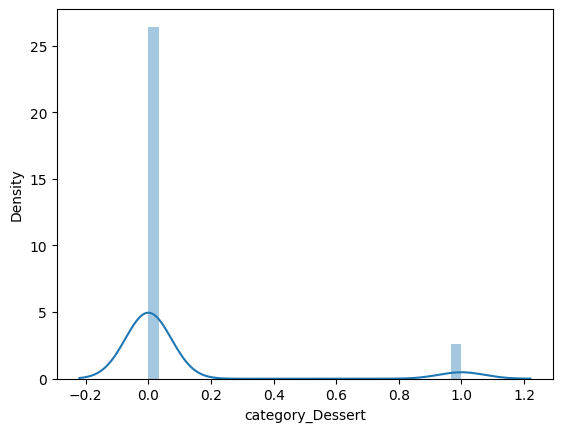

/tmp/ipykernel_7388/2609660079.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col])


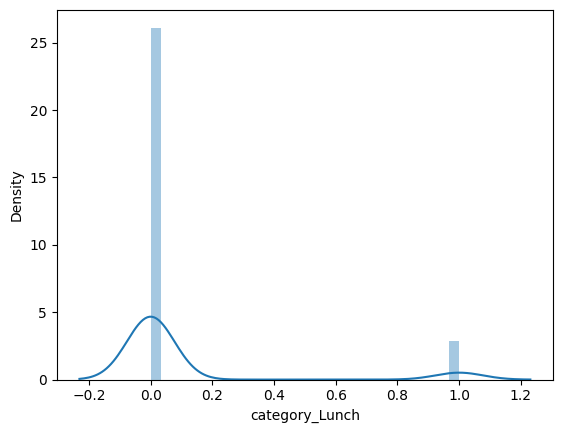

/tmp/ipykernel_7388/2609660079.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col])


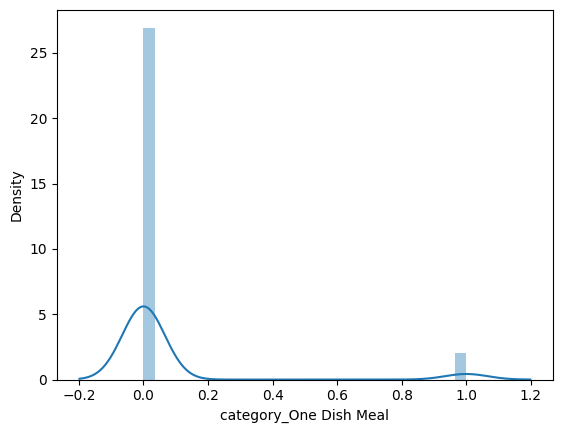

/tmp/ipykernel_7388/2609660079.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col])


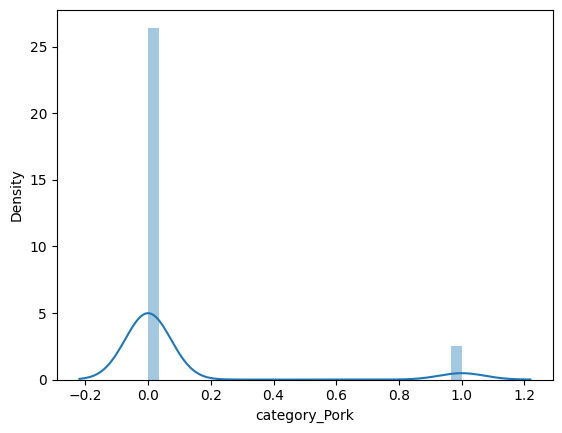

/tmp/ipykernel_7388/2609660079.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col])


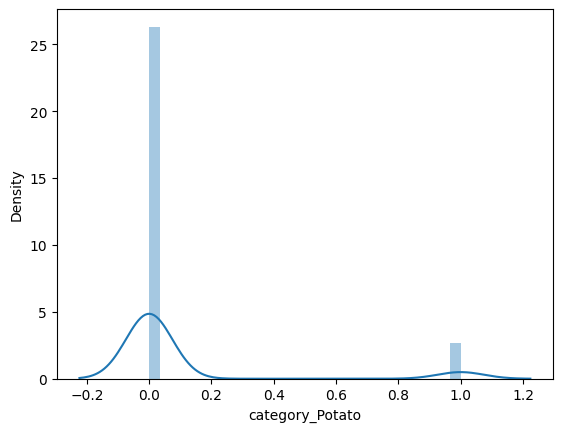

/tmp/ipykernel_7388/2609660079.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col])


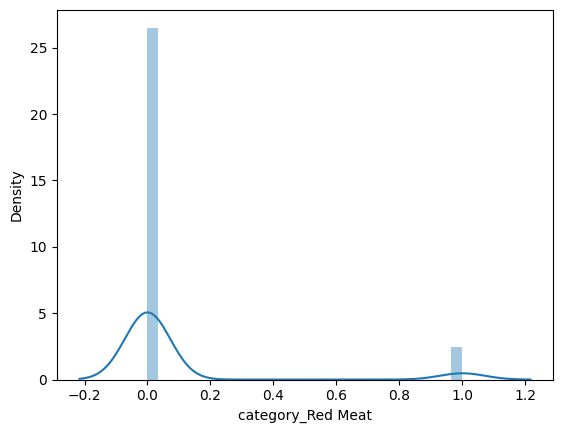

/tmp/ipykernel_7388/2609660079.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col])


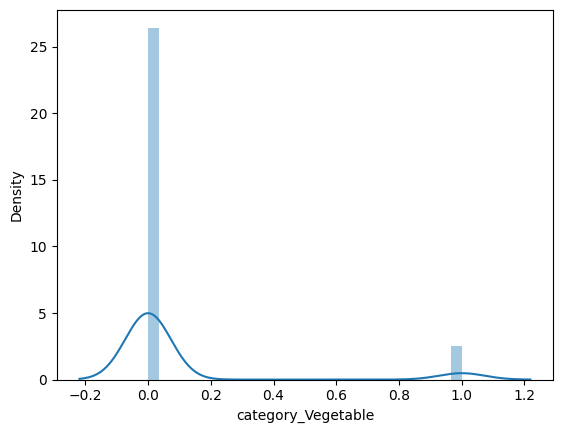

/tmp/ipykernel_7388/2609660079.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col])


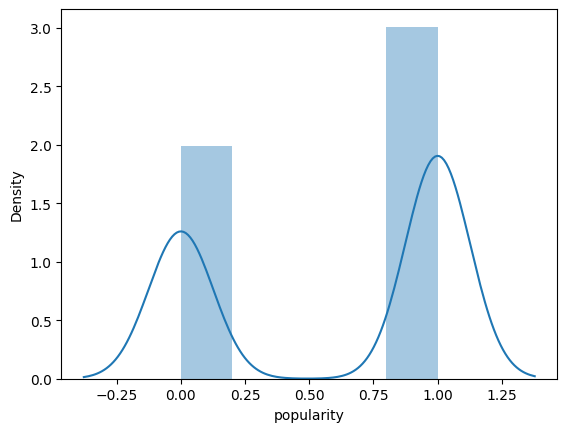

In [366]:

#plot distributions of calories, carbohydrate, sugar and protein
plot_distributions(df)

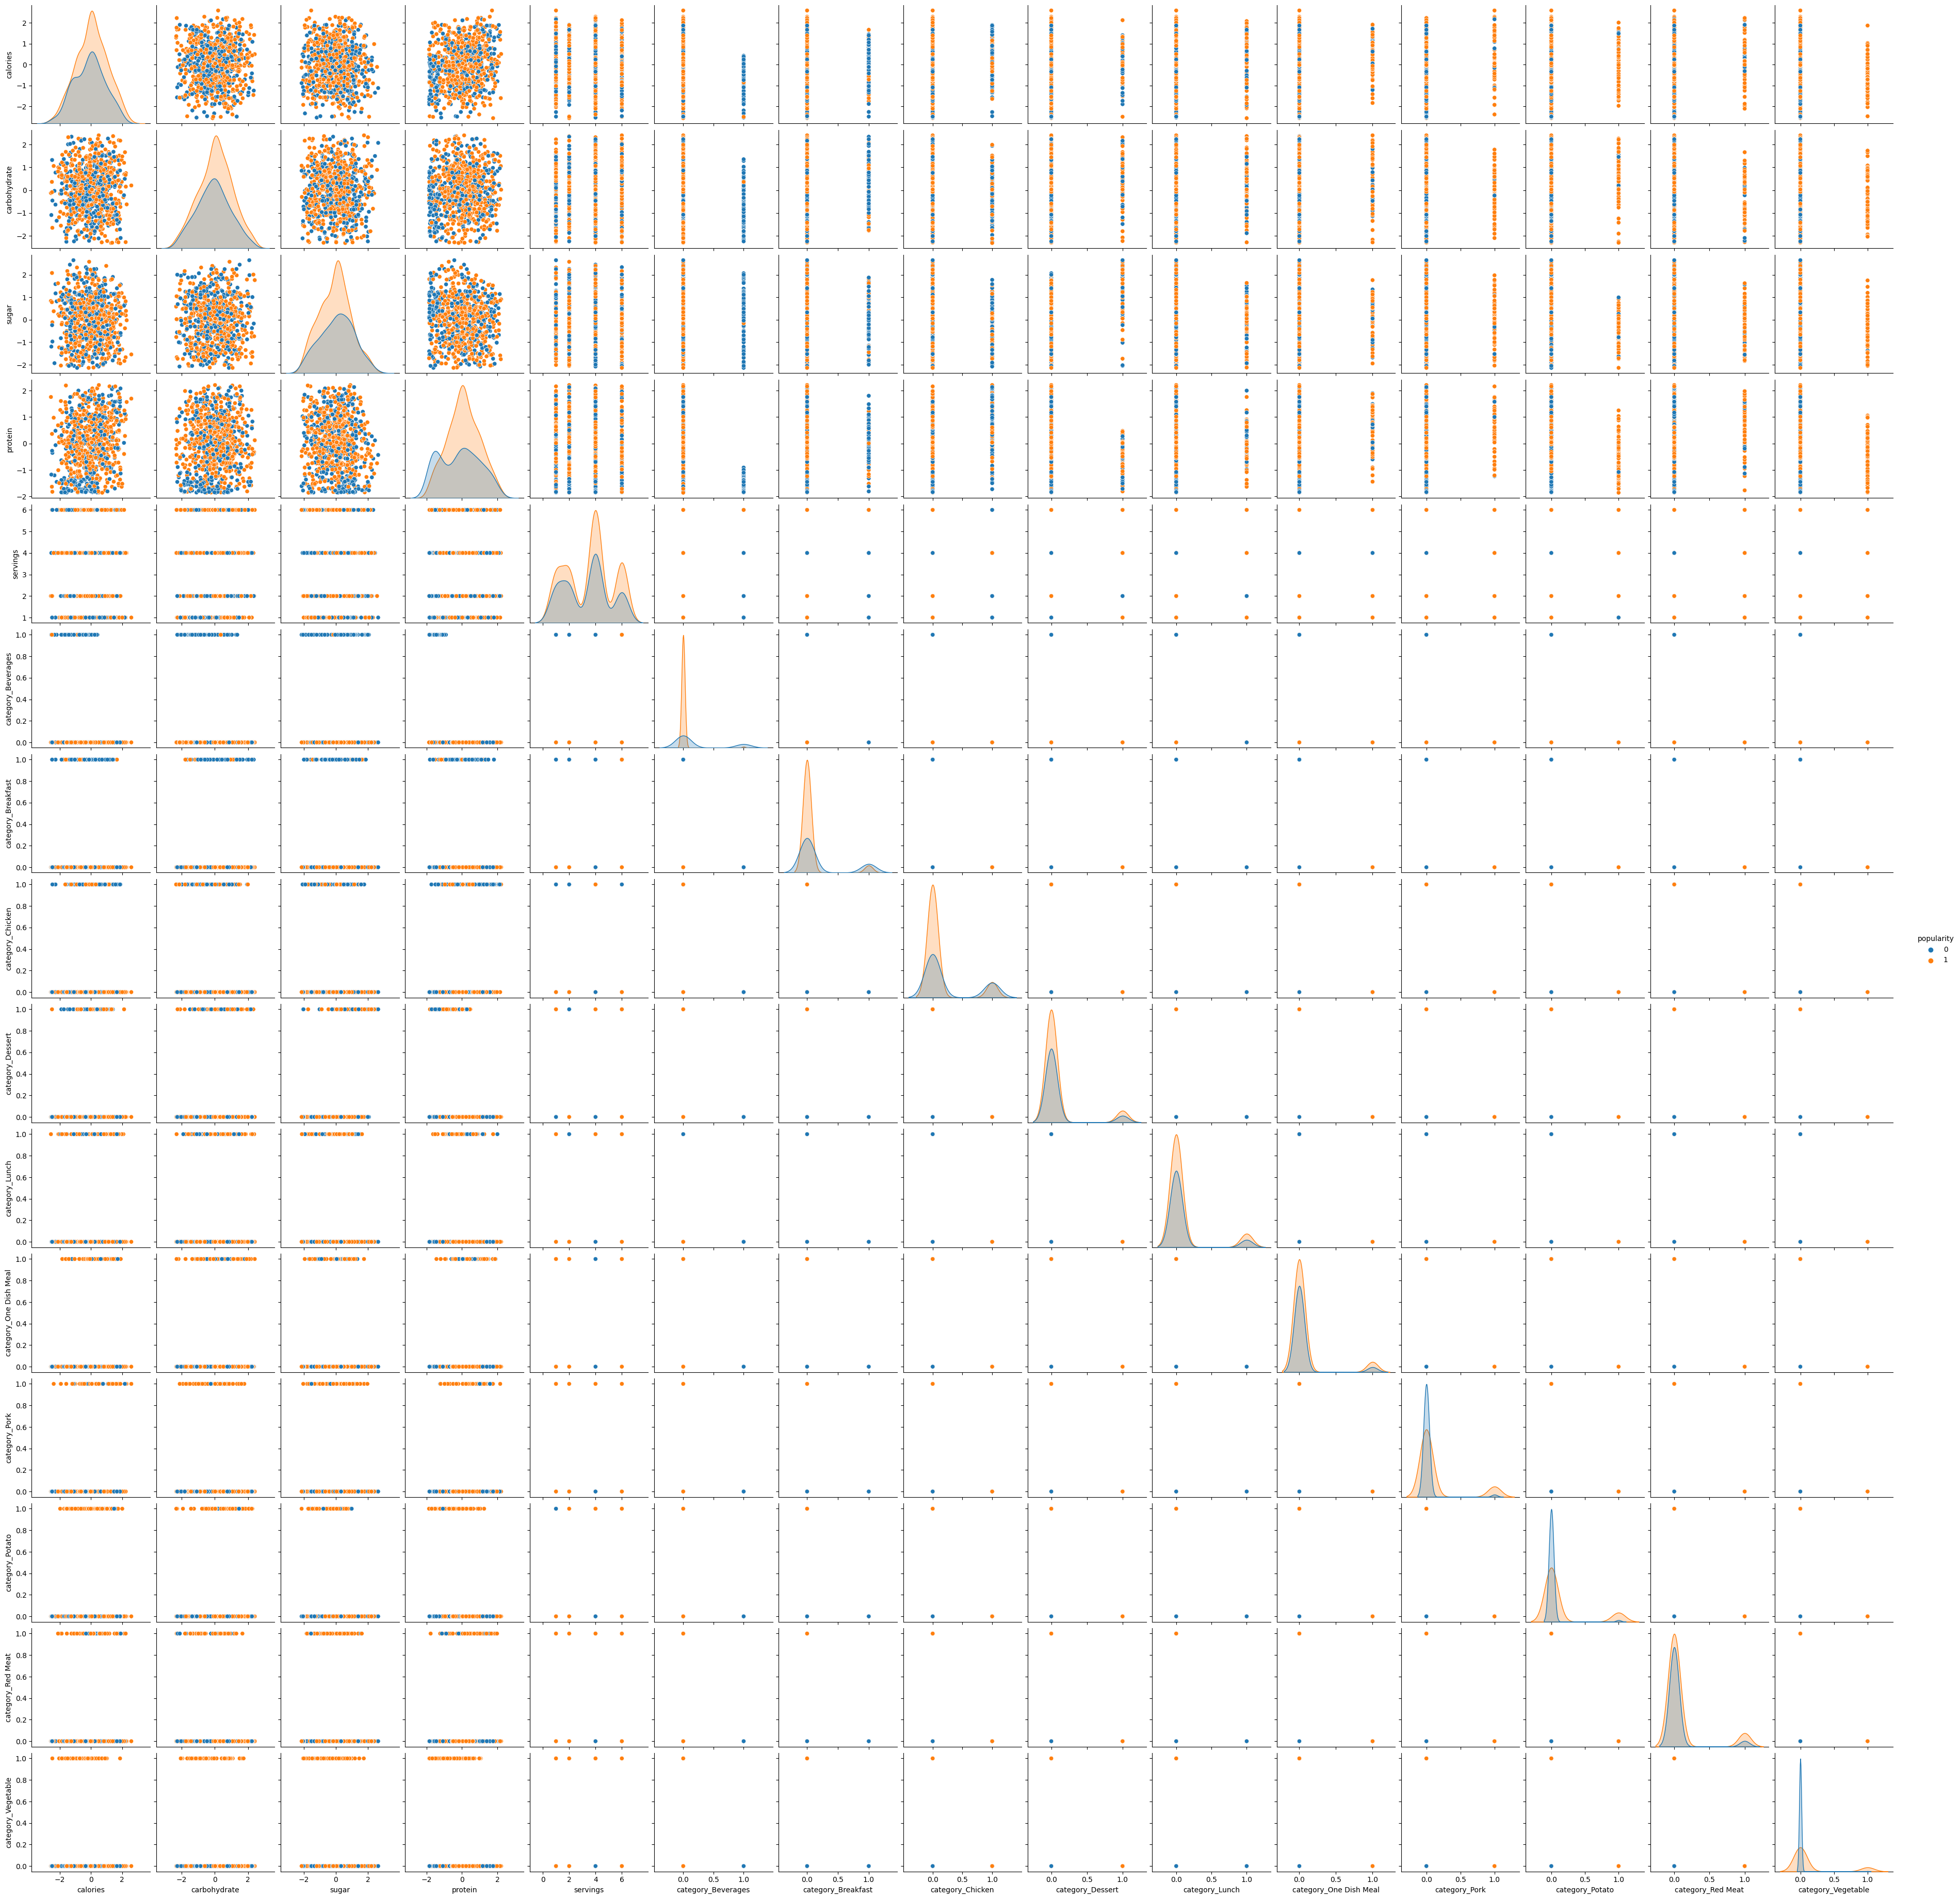

In [367]:
#seaborn pairplot of df
sns.pairplot(df, hue='popularity')
plt.show()

Just to see the feature importance from Random Forest Classifier

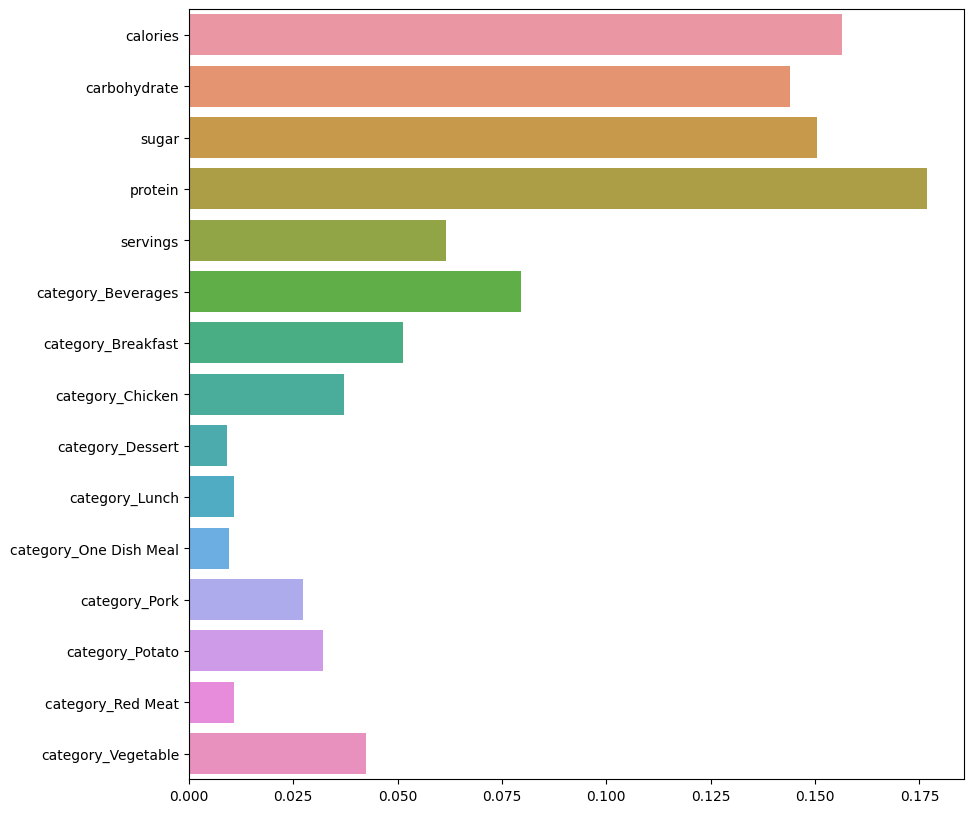

In [368]:
# perform feature importance with random forest classifier
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
X = df.drop('popularity', axis=1)
y = df['popularity']
rfc.fit(X, y)
rfc.feature_importances_

#plot feature importance
plt.figure(figsize=(10,10))
sns.barplot(x=rfc.feature_importances_, y=X.columns)
plt.show()


## Standardizing data

In [369]:
df.head()

calories  carbohydrate     sugar   protein  servings  \
recipe                                                         
1       0.056613      0.028481  0.053689  0.041637         6   
2      -1.418210      0.594509 -1.418608 -1.375496         4   
3       1.343435      0.698965 -0.285469 -0.840193         1   
4      -0.822332      0.362249  1.801352 -1.842467         4   
5      -1.550215     -1.663283 -1.308219 -1.544664         4   

        category_Beverages  category_Breakfast  category_Chicken  \
recipe                                                             
1                        0                   0                 0   
2                        0                   0                 0   
3                        0                   1                 0   
4                        1                   0                 0   
5                        1                   0                 0   

        category_Dessert  category_Lunch  category_One Dish Meal  \
recipe                                                             
1                      0               0                       0   
2                      0               0                       0   
3                      0               0                       0   
4                      0               0                       0   
5                      0               0                       0   

        category_Pork  category_Potato  category_Red Meat  category_Vegetable  \
recipe                                                                          
1                   1                0                  0                   0   
2                   0                1                  0                   0   
3                   0                0                  0                   0   
4                   0                0                  0                   0   
5                   0                0                  0                   0   

        popularity  
recipe              
1                1  
2                1  
3                0  
4                1  
5                0

In [370]:
#use standard caler to scale calories, carbohydrate, sugar, protein and servings
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
 
df[['calories', 'carbohydrate', 'sugar', 'protein', 'servings']] = scaler.fit_transform(df[['calories', 'carbohydrate', 'sugar', 'protein', 'servings']])
df.head()


calories  carbohydrate     sugar   protein  servings  \
recipe                                                         
1       0.056613      0.028481  0.053689  0.041637  1.455519   
2      -1.418210      0.594509 -1.418608 -1.375496  0.296591   
3       1.343435      0.698965 -0.285469 -0.840193 -1.441800   
4      -0.822332      0.362249  1.801352 -1.842467  0.296591   
5      -1.550215     -1.663283 -1.308219 -1.544664  0.296591   

        category_Beverages  category_Breakfast  category_Chicken  \
recipe                                                             
1                        0                   0                 0   
2                        0                   0                 0   
3                        0                   1                 0   
4                        1                   0                 0   
5                        1                   0                 0   

        category_Dessert  category_Lunch  category_One Dish Meal  \
recipe                                                             
1                      0               0                       0   
2                      0               0                       0   
3                      0               0                       0   
4                      0               0                       0   
5                      0               0                       0   

        category_Pork  category_Potato  category_Red Meat  category_Vegetable  \
recipe                                                                          
1                   1                0                  0                   0   
2                   0                1                  0                   0   
3                   0                0                  0                   0   
4                   0                0                  0                   0   
5                   0                0                  0                   0   

        popularity  
recipe              
1                1  
2                1  
3                0  
4                1  
5                0

## Splitting data

In [371]:
#split data into train and test sets
from sklearn.model_selection import train_test_split
X = df.drop('popularity', axis=1)
y = df['popularity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)


# Baselines

In [372]:
#automl with h2o to see a list of models and baselines on train and test splits
import h2o
from h2o.automl import H2OAutoML
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


--------------------------  -------------------------------
H2O_cluster_uptime:         1 hour 43 mins
H2O_cluster_timezone:       Europe/Paris
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.42.0.4
H2O_cluster_version_age:    14 days, 6 hours and 29 minutes
H2O_cluster_name:           H2O_from_python_root_rcjehe
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    7.797 Gb
H2O_cluster_total_cores:    8
H2O_cluster_allowed_cores:  8
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://localhost:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
Python_version:             3.10.12 final
--------------------------  -------------------------------

In [423]:
h2o.init()
df_h2o = h2o.H2OFrame(df)
df_h2o['popularity'] = df_h2o['popularity'].asfactor()
#split data into train and test sets
train, test = df_h2o.split_frame(ratios=[0.8], seed=1)
aml = H2OAutoML(max_models=30, seed=1, nfolds=30, balance_classes=True, max_after_balance_size=0.3, sort_metric='auc')
aml.train(y='popularity', training_frame=train, validation_frame=test)
#check leaderboard
lb = aml.leaderboard
lb.head()
#check leaderboard again
lb.head(rows=lb.nrows)



Checking whether there is an H2O instance running at http://localhost:54321. connected.


--------------------------  -------------------------------
H2O_cluster_uptime:         1 hour 58 mins
H2O_cluster_timezone:       Europe/Paris
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.42.0.4
H2O_cluster_version_age:    14 days, 6 hours and 44 minutes
H2O_cluster_name:           H2O_from_python_root_rcjehe
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    7.437 Gb
H2O_cluster_total_cores:    8
H2O_cluster_allowed_cores:  8
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://localhost:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
Python_version:             3.10.12 final
--------------------------  -------------------------------

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
21:42:41.684: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.

███████████████████████████████████████████████████████████████| (done) 100%


model_id                                                      auc    logloss     aucpr    mean_per_class_error      rmse       mse
-------------------------------------------------------  --------  ---------  --------  ----------------------  --------  --------
StackedEnsemble_AllModels_1_AutoML_4_20231017_214241     0.822545   0.490724  0.879092                0.323688  0.403666  0.162947
StackedEnsemble_BestOfFamily_1_AutoML_4_20231017_214241  0.809469   0.504008  0.866878                0.32818   0.410279  0.168329
GLM_1_AutoML_4_20231017_214241                           0.79635    0.505969  0.858911                0.331396  0.411572  0.169392
DeepLearning_grid_1_AutoML_4_20231017_214241_model_1     0.795734   0.637534  0.846423                0.343537  0.441567  0.194981
DeepLearning_grid_3_AutoML_4_20231017_214241_model_1     0.794531   0.722011  0.839812                0.294595  0.443736  0.196901
DeepLearning_grid_2_AutoML_4_20231017_214241_model_1     0.790577   0.7284    0.841882                0.291983  0.449811  0.20233
GBM_grid_1_AutoML_4_20231017_214241_model_2              0.789573   0.523413  0.866733                0.339967  0.421179  0.177391
DeepLearning_grid_3_AutoML_4_20231017_214241_model_2     0.784425   0.543593  0.851142                0.344554  0.425399  0.180964
DeepLearning_grid_2_AutoML_4_20231017_214241_model_2     0.783425   0.584474  0.85881                 0.368387  0.439516  0.193175
DeepLearning_grid_1_AutoML_4_20231017_214241_model_2     0.781981   0.72822   0.859157                0.351564  0.46232   0.21374
GBM_4_AutoML_4_20231017_214241                           0.781239   0.531629  0.850723                0.307245  0.424639  0.180318
GBM_grid_1_AutoML_4_20231017_214241_model_5              0.778187   0.540945  0.852709                0.377785  0.428393  0.18352
XGBoost_grid_1_AutoML_4_20231017_214241_model_1          0.774492   0.544969  0.849183                0.385209  0.430336  0.185189
DeepLearning_1_AutoML_4_20231017_214241                  0.773052   0.597729  0.83877                 0.341941  0.441335  0.194776
DRF_1_AutoML_4_20231017_214241                           0.772483   0.59741   0.849715                0.344968  0.433754  0.188143
XGBoost_grid_1_AutoML_4_20231017_214241_model_7          0.767943   0.556104  0.842224                0.353634  0.434726  0.188987
GBM_grid_1_AutoML_4_20231017_214241_model_1              0.759894   0.548523  0.833368                0.359402  0.431197  0.185931
XGBoost_3_AutoML_4_20231017_214241                       0.759321   0.582734  0.842174                0.388968  0.447904  0.200618
XGBoost_2_AutoML_4_20231017_214241                       0.758239   0.584751  0.834591                0.377975  0.447047  0.199851
XGBoost_grid_1_AutoML_4_20231017_214241_model_6          0.757747   0.566363  0.832965                0.372146  0.439322  0.193004
GBM_grid_1_AutoML_4_20231017_214241_model_3              0.756264   0.55176   0.835222                0.370171  0.433241  0.187698
GBM_grid_1_AutoML_4_20231017_214241_model_4              0.755859   0.556587  0.81244                 0.341114  0.433217  0.187677
GBM_2_AutoML_4_20231017_214241                           0.747568   0.561727  0.835138                0.400152  0.43953   0.193187
GBM_3_AutoML_4_20231017_214241                           0.747405   0.570346  0.825983                0.34452   0.44144   0.194869
XGBoost_grid_1_AutoML_4_20231017_214241_model_2          0.744111   0.594729  0.820246                0.396806  0.449597  0.202137
XGBoost_grid_1_AutoML_4_20231017_214241_model_5          0.739498   0.652097  0.828821                0.398048  0.469489  0.22042
XGBoost_grid_1_AutoML_4_20231017_214241_model_3          0.73573    0.578376  0.81237                 0.379441  0.444598  0.197668
GBM_5_AutoML_4_20231017_214241                           0.732841   0.567122  0.821476                0.376957  0.441911  0.195285
XGBoost_grid_1_AutoML_4_20231017_214241_model_4          0.726042   0.5812

model_id                                              auc    logloss     aucpr    mean_per_class_error      rmse       mse    training_time_ms    predict_time_per_row_ms  algo
-----------------------------------------------  --------  ---------  --------  ----------------------  --------  --------  ------------------  -------------------------  -------
GLM_1_AutoML_4_20231017_214241                   0.861365   0.458381  0.880446                0.211295  0.390087  0.152168                  30                   0.048631  GLM
XGBoost_grid_1_AutoML_4_20231017_214241_model_1  0.825123   0.515446  0.822071                0.284131  0.414069  0.171453                 606                   0.045108  XGBoost
XGBoost_2_AutoML_4_20231017_214241               0.816796   0.523171  0.834661                0.275158  0.419489  0.175971                 489                   0.044216  XGBoost
GBM_3_AutoML_4_20231017_214241                   0.813863   0.530413  0.846805                0.225897  0.421611  0.177756                  77                   0.039935  GBM
XGBoost_grid_1_AutoML_4_20231017_214241_model_4  0.764837   0.587639  0.726912                0.294335  0.444984  0.198011                1993                   0.039573  XGBoost
[5 rows x 10 columns]

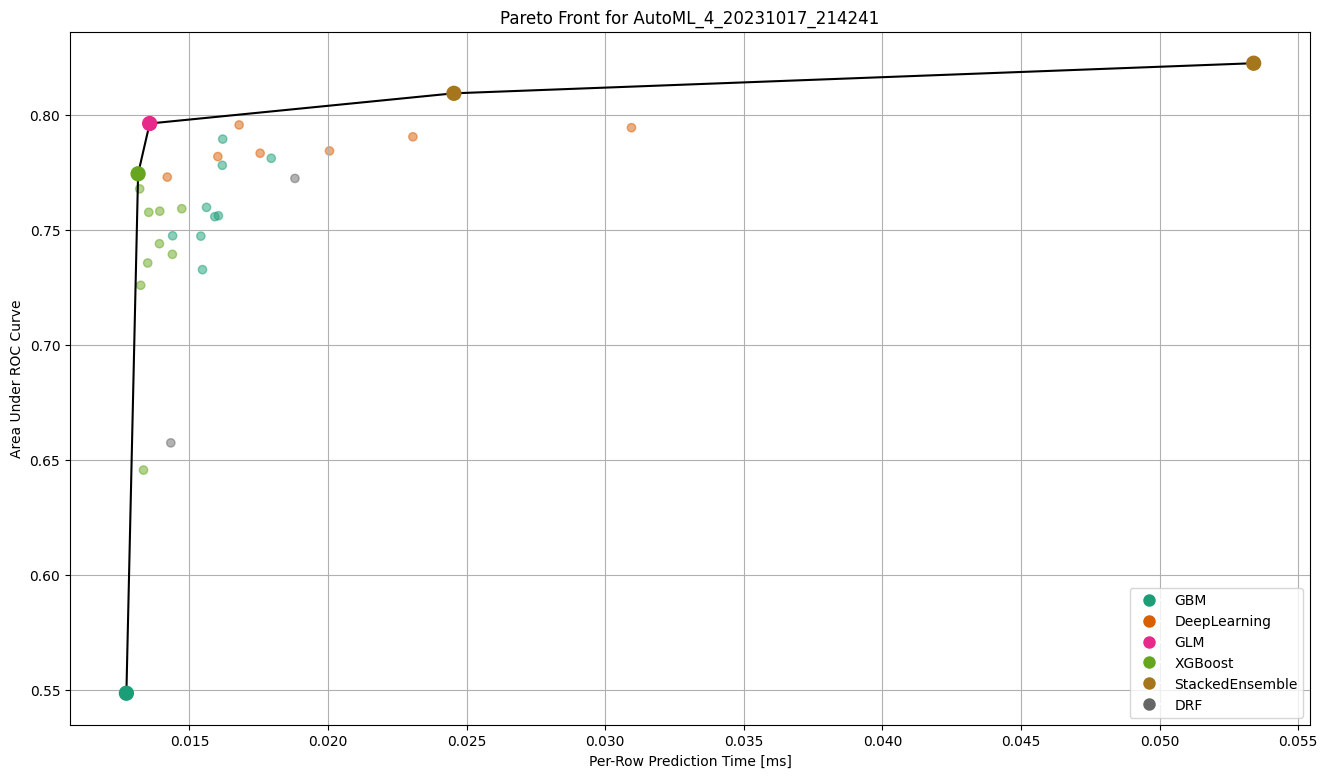

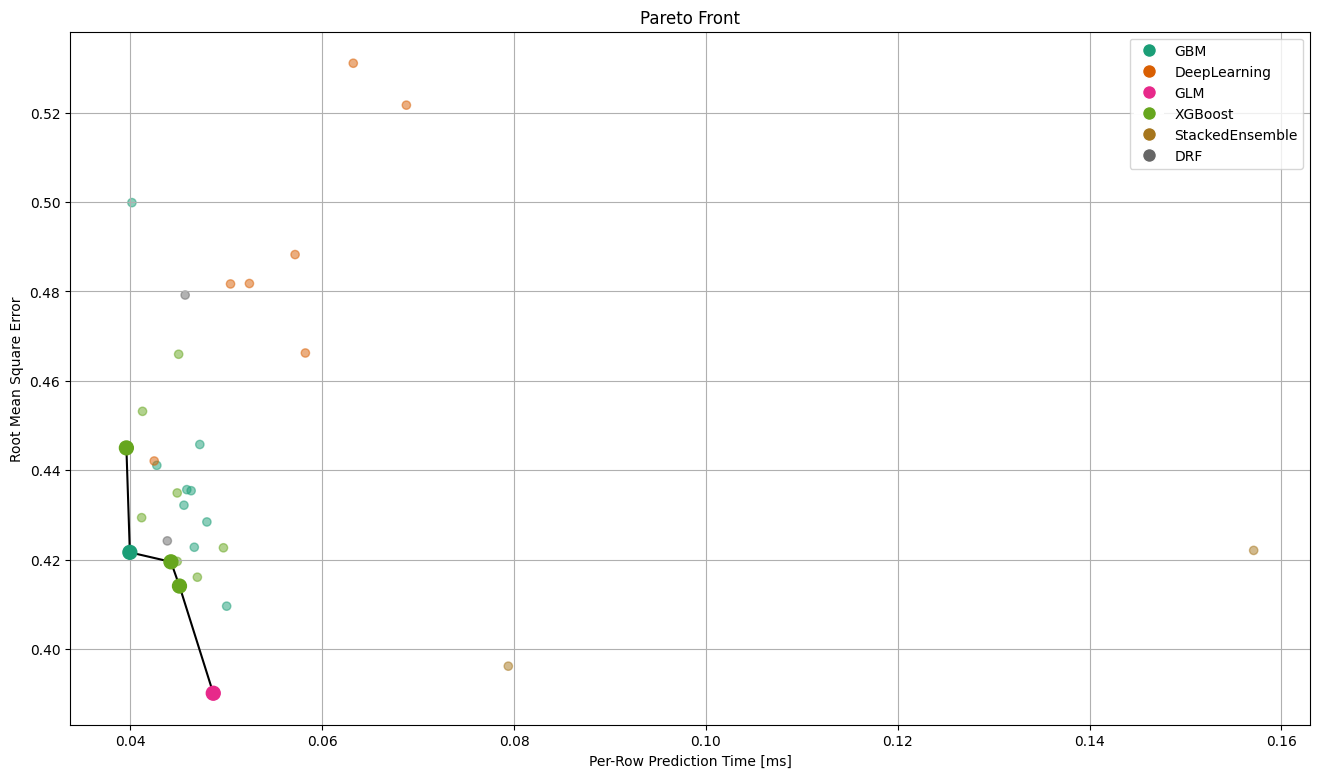

In [444]:
#show paretto front plot for automl aml
pf = aml.pareto_front()
pf.figure() # get the Pareto front plot
pf # H2OFrame containing the Pareto front subset of the leaderboard

combined_leaderboard = h2o.make_leaderboard([aml], test, extra_columns="ALL")
pf = h2o.explanation.pareto_front(combined_leaderboard, x_metric="predict_time_per_row_ms", y_metric="rmse", optimum="bottom left")
pf.figure() # get the Pareto front plot
pf # H2OFrame containing the Pareto front subset of the leaderboard

In [424]:
# save best model
model_path = h2o.save_model(model=aml.leader, path="recipe_site_traffic_model_10172023", force=True)

In [425]:

#load model
model = h2o.load_model('recipe_site_traffic_model_10172023/StackedEnsemble_AllModels_1_AutoML_4_20231017_214241')

#show model performance
model.model_performance()
 
    
#show model performance on training data
model.model_performance(train=True)
 
 
#show model performance on test data
model.model_performance(valid=True)
 
 
#show model performance on cross validation data
model.model_performance(xval=True)

ModelMetricsBinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.1629465534194169
RMSE: 0.40366638876604144
LogLoss: 0.49072420981188153
AUC: 0.8225451817617438
AUCPR: 0.879091525373175
Gini: 0.6450903635234877
Null degrees of freedom: 701
Residual degrees of freedom: 692
Null deviance: 933.2925963260211
Residual deviance: 688.9767905758816
AIC: 708.9767905758816

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3738460470756895
       0    1    Error    Rate
-----  ---  ---  -------  -------------
0      106  160  0.6015   (160.0/266.0)
1      20   416  0.0459   (20.0/436.0)
Total  126  576  0.2564   (180.0/702.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.373846     0.822134  308
max f2                       0.272483     0.90736   339
max f0point5                 0.61378      0.809547  210
max accuracy                 0.508913     0.75641   248
max precision                0.998526     1         0
max recall                   0.0538803    1         383
max specificity              0.998526     1         0
max absolute_mcc             0.61378      0.481324  210
max min_per_class_accuracy   0.620496     0.743119  206
max mean_per_class_accuracy  0.61378      0.745715  210
max tns                      0.998526     266       0
max fns                      0.998526     434       0
max fps                      0.00260293   266       399
max tps                      0.0538803    436       383
max tnr                      0.998526     1         0
max fnr                      0.998526     0.995413  0
max fpr                      0.00260293   1         399
max tpr                      0.0538803    1         383

Gains/Lift Table: Avg response rate: 62.11 %, avg score: 62.13 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.011396                    0.993459           1.61009   1.61009            1                0.995965   1                           0.995965            0.0183486       0.0183486                  61.0092   61.0092            0.0183486
2        0.0213675                   0.98928            1.61009   1.61009            1                0.991421   1                           0.993844            0.016055        0.0344037                  61.0092   61.0092            0.0344037
3        0.031339                    0.9819             1.61009   1.61009            1                0.98554    1                           0.991202            0.016055        0.0504587                  61.0092   61.0092            0.0504587
4        0.0413105                   0.977702           1.61009   1.61009            1                0.979852   1                           0.988462            0.016055        0.0665138                  61.0092   61.0092            0.0665138
5        0.0512821                   0.966199           1.15007   1.52064            0.714286         0.97021    0.944444                    0.984913            0.0114679       0.0779817                  15.0066   52.0642            0.0704629
6        0.10114                     0.939819           1.61009   1.56474            1                0.951988   0.971831                    0.968682            0.0802752       0.158257                   61.0092   56.4737            0.150738
7        0.150997                    0.920629           1.47208   1.53414            0.914286         0.930051   0.95283                     0

In [426]:
#use model to predict on test data
pred = model.predict(test)

#show predictions
pred

#show predictions as pandas dataframe
pred_df = pred.as_data_frame()
pred_df


stackedensemble prediction progress: |

███████████████████████████████████████████| (done) 100%


predict        p0        p1
0          0  0.919553  0.080447
1          1  0.553017  0.446983
2          1  0.000615  0.999385
3          1  0.003219  0.996781
4          0  0.942521  0.057479
..       ...       ...       ...
180        0  0.773337  0.226663
181        1  0.451193  0.548807
182        1  0.000851  0.999149
183        1  0.361031  0.638969
184        1  0.053423  0.946577

[185 rows x 3 columns]

In [427]:

#show predictions as pandas dataframe with actual values
pred_df = pred.as_data_frame()
pred_df['actual'] = test['popularity'].as_data_frame()
pred_df

 

predict        p0        p1  actual
0          0  0.919553  0.080447       0
1          1  0.553017  0.446983       0
2          1  0.000615  0.999385       1
3          1  0.003219  0.996781       1
4          0  0.942521  0.057479       0
..       ...       ...       ...     ...
180        0  0.773337  0.226663       0
181        1  0.451193  0.548807       1
182        1  0.000851  0.999149       1
183        1  0.361031  0.638969       1
184        1  0.053423  0.946577       1

[185 rows x 4 columns]

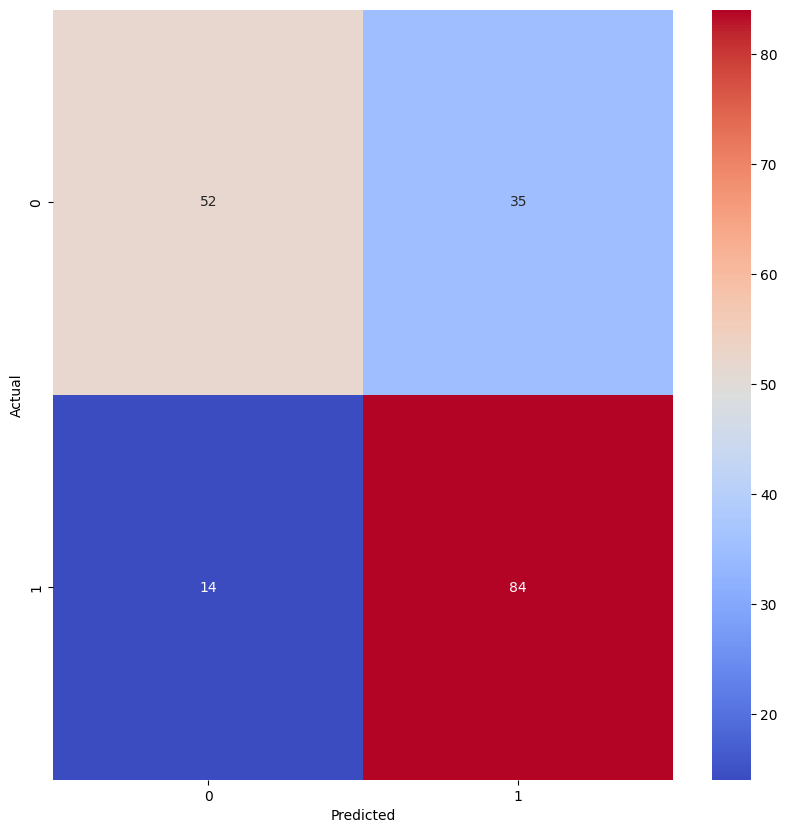

In [428]:
#plot confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(pred_df['actual'], pred_df['predict'])
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, cmap='coolwarm')
plt.xlabel('Predicted')
plt.ylabel('Actual')    
plt.show()


In [429]:

#show classification report
from sklearn.metrics import classification_report
print(classification_report(pred_df['actual'], pred_df['predict']))


              precision    recall  f1-score   support

           0       0.79      0.60      0.68        87
           1       0.71      0.86      0.77        98

    accuracy                           0.74       185
   macro avg       0.75      0.73      0.73       185
weighted avg       0.74      0.74      0.73       185



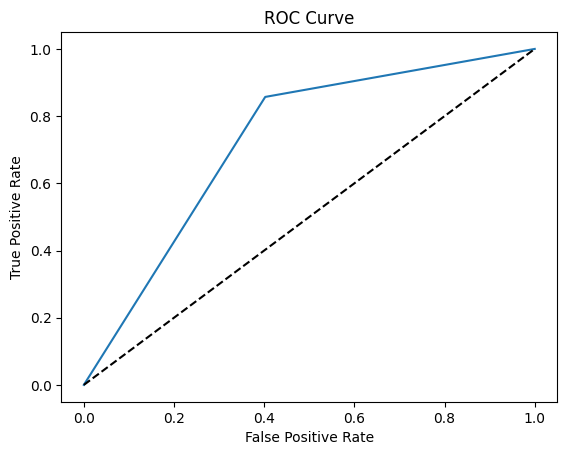

In [430]:

#show roc curve
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(pred_df['actual'], pred_df['predict'])
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()


In [431]:

#show auc score
from sklearn.metrics import roc_auc_score
roc_auc_score(pred_df['actual'], pred_df['predict'])


0.7274220032840722

In [432]:

#show accuracy score
from sklearn.metrics import accuracy_score
accuracy_score(pred_df['actual'], pred_df['predict'])


0.7351351351351352

In [433]:

#show precision score
from sklearn.metrics import precision_score
precision_score(pred_df['actual'], pred_df['predict'])


0.7058823529411765

In [434]:

#show recall score
from sklearn.metrics import recall_score
recall_score(pred_df['actual'], pred_df['predict'])


0.8571428571428571

In [435]:

#show f1 score
from sklearn.metrics import f1_score    
f1_score(pred_df['actual'], pred_df['predict'])



0.7741935483870968

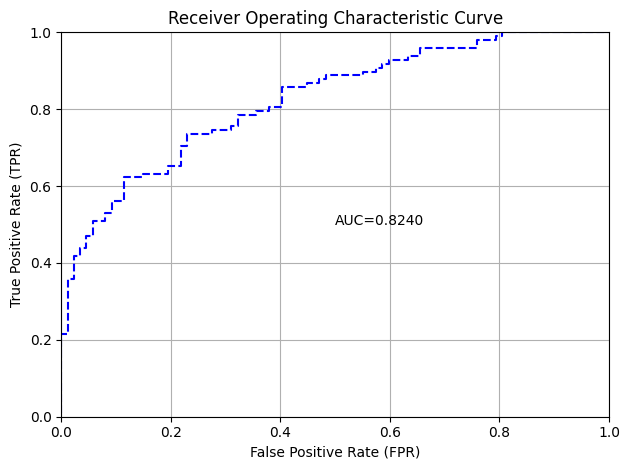

In [436]:
#plot auc curve
model.model_performance(valid=True).plot()
plt.show()
 

PartialDependencePlot progress: |

████████████████████████████████████████████████| (done) 100%


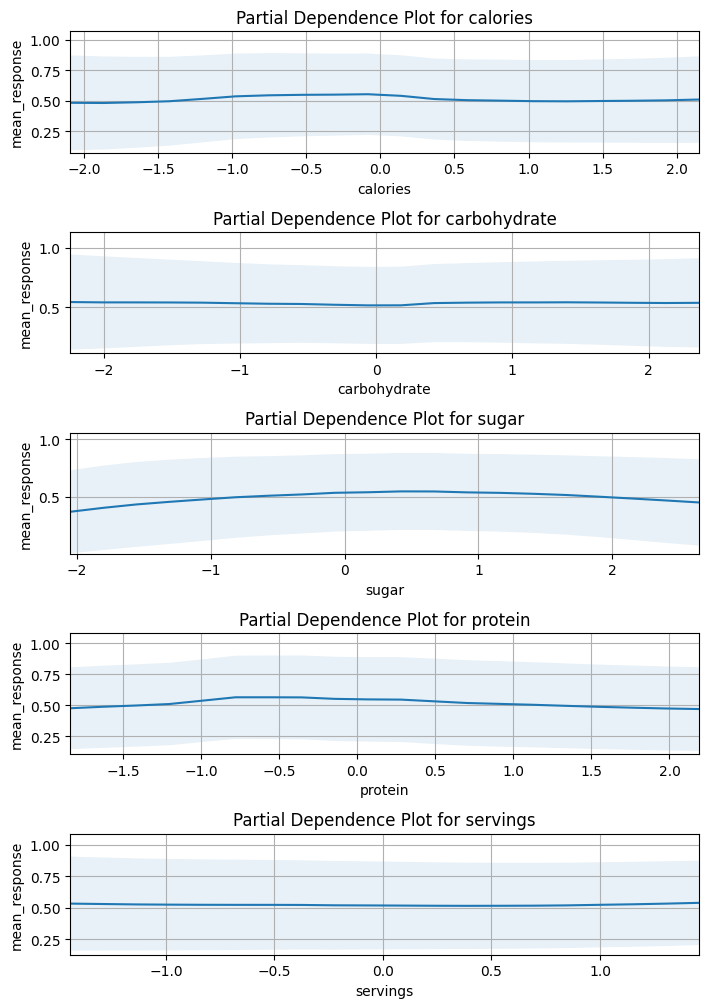

In [441]:
#plot partial dependence plot
model.partial_plot(data=test, cols=['calories', 'carbohydrate', 'sugar', 'protein', 'servings'])
plt.show()


    

# Model 1. XGBoost

xgboost Model Build progress: |

/usr/local/lib/python3.10/dist-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: early stopping is enabled but neither score_tree_interval or score_each_iteration are defined. Early stopping will not be reproducible!
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████| (done) 100%


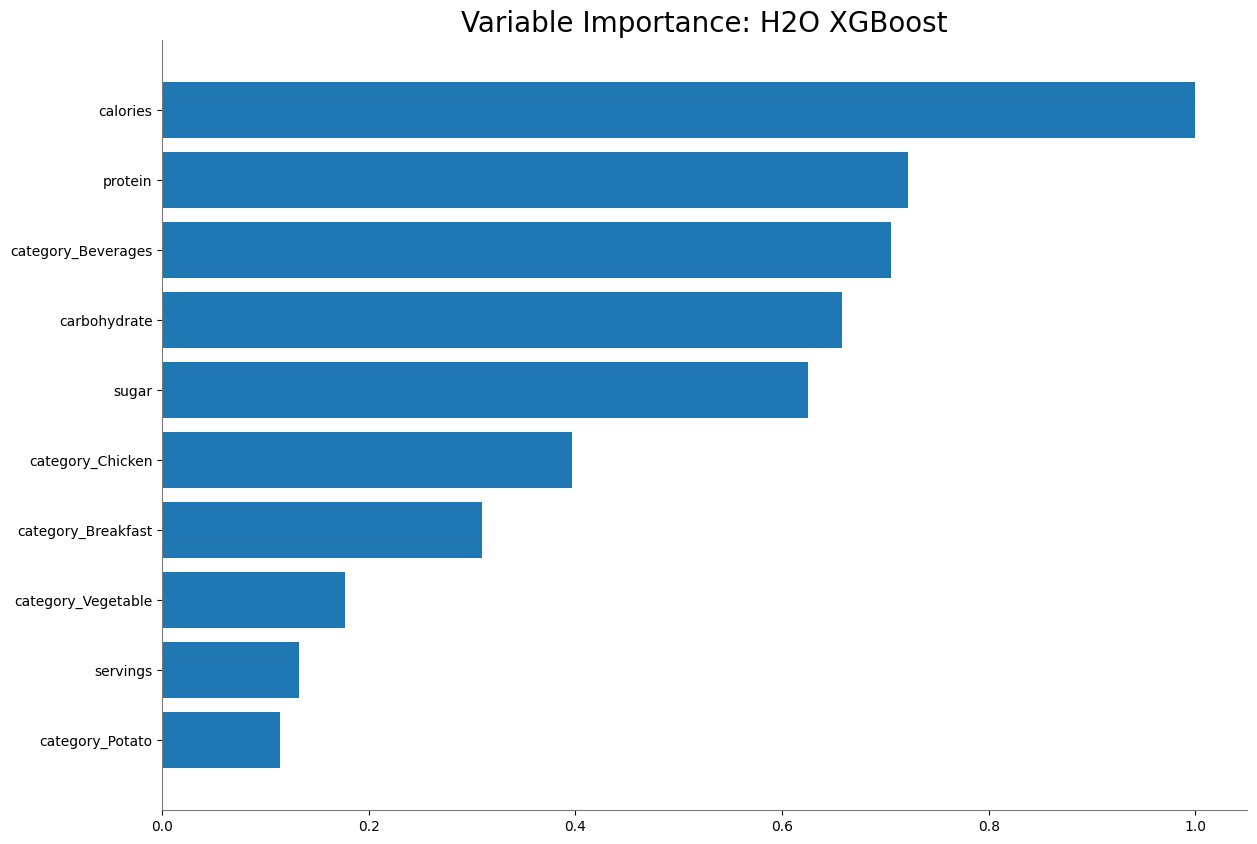

<Figure size 640x480 with 0 Axes>

In [387]:
from h2o.estimators import H2OXGBoostEstimator

xgb = H2OXGBoostEstimator(nfolds=100, seed=1, keep_cross_validation_predictions=True, 
                          stopping_rounds=50, stopping_tolerance=0.001, stopping_metric='auc') 

xgb.train(y='popularity', training_frame=train, validation_frame=test)
xgb.varimp_plot()



In [388]:


#save model
h2o.save_model(model=xgb, path='recipe_site_traffic_model_xgb', force=True)


'/root/datacamp_professional/recipe_site_traffic_model_xgb/XGBoost_model_python_1697564644145_5581'

In [389]:

#load model
model = h2o.load_model('recipe_site_traffic_model_xgb/XGBoost_model_python_1697485883597_7117')

#show model performance
model.model_performance()

#show model performance on training data
model.model_performance(train=True)

#show model performance on test data
model.model_performance(valid=True)

#show model performance on cross validation data
model.model_performance(xval=True)

ModelMetricsBinomial: xgboost
** Reported on cross-validation data. **

MSE: 0.20852758750205252
RMSE: 0.4566482097874167
LogLoss: 0.6391010429751706
Mean Per-Class Error: 0.3853038559702007
AUC: 0.753048044422984
AUCPR: 0.8340769521850496
Gini: 0.506096088845968

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.16719401627779007
       0    1    Error    Rate
-----  ---  ---  -------  -------------
0      72   194  0.7293   (194.0/266.0)
1      18   418  0.0413   (18.0/436.0)
Total  90   612  0.302    (212.0/702.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.167194     0.79771   343
max f2                       0.0719817    0.892783  372
max f0point5                 0.809741     0.759494  122
max accuracy                 0.476411     0.707977  246
max precision                0.998105     1         0
max recall                   0.0017871    1         399
max specificity              0.998105     1         0
max absolute_mcc             0.826415     0.37429   117
max min_per_class_accuracy   0.667305     0.662844  179
max mean_per_class_accuracy  0.809741     0.688763  122
max tns                      0.998105     266       0
max fns                      0.998105     433       0
max fps                      0.00509835   266       397
max tps                      0.0017871    436       399
max tnr                      0.998105     1         0
max fnr                      0.998105     0.993119  0
max fpr                      0.00509835   1         397
max tpr                      0.0017871    1         399

Gains/Lift Table: Avg response rate: 62.11 %, avg score: 63.06 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.011396                    0.996998           1.61009   1.61009            1                0.997487   1                           0.997487            0.0183486       0.0183486                  61.0092   61.0092            0.0183486
2        0.0213675                   0.995491           1.61009   1.61009            1                0.996234   1                           0.996902            0.016055        0.0344037                  61.0092   61.0092            0.0344037
3        0.031339                    0.994579           1.61009   1.61009            1                0.995038   1                           0.996309            0.016055        0.0504587                  61.0092   61.0092            0.0504587
4        0.0413105                   0.993161           1.61009   1.61009            1                0.994018   1                           0.995756            0.016055        0.0665138                  61.0092   61.0092            0.0665138
5        0.0512821                   0.991088           1.15007   1.52064            0.714286         0.992071   0.944444                    0.99504             0.0114679       0.0779817                  15.0066   52.0642            0.0704629
6        0.10114                     0.985143           1.47208   1.49671            0.914286         0.988362   0.929577                    0.991748            0.0733945       0.151376                   47.2084   49.6705            0.132579
7        0.150997                    0.972814           1.47208   1.48858            0.914286         0.979214   0.924528                    0.987609            0.0733945       0.224771                   47.2084   48.8575            0.194695
8        0.200855         

In [390]:
#use model to predict on test data
pred = model.predict(test)
 
#show predictions
pred

#show predictions as pandas dataframe
pred_df = pred.as_data_frame()
pred_df


xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


predict        p0        p1
0          0  0.736651  0.263349
1          1  0.496988  0.503012
2          1  0.025684  0.974316
3          1  0.201590  0.798410
4          1  0.517197  0.482802
..       ...       ...       ...
180        1  0.387039  0.612961
181        1  0.266220  0.733780
182        1  0.007317  0.992683
183        1  0.063733  0.936267
184        1  0.028486  0.971514

[185 rows x 3 columns]

In [391]:

#show predictions as pandas dataframe with actual values
pred_df = pred.as_data_frame()
pred_df['actual'] = test['popularity'].as_data_frame()
pred_df



predict        p0        p1  actual
0          0  0.736651  0.263349       0
1          1  0.496988  0.503012       0
2          1  0.025684  0.974316       1
3          1  0.201590  0.798410       1
4          1  0.517197  0.482802       0
..       ...       ...       ...     ...
180        1  0.387039  0.612961       0
181        1  0.266220  0.733780       1
182        1  0.007317  0.992683       1
183        1  0.063733  0.936267       1
184        1  0.028486  0.971514       1

[185 rows x 4 columns]

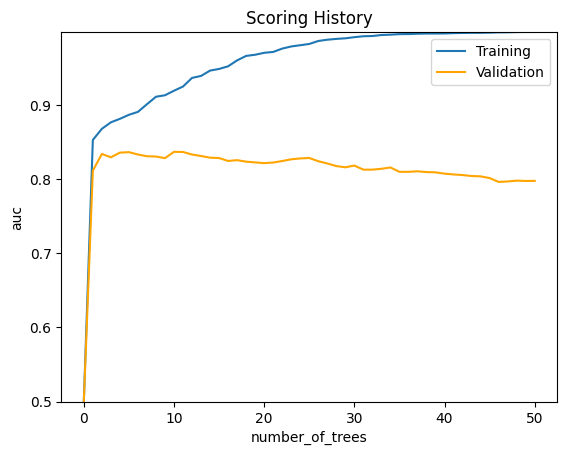

In [392]:
#plot auc
model.plot(metric='auc')

 
  


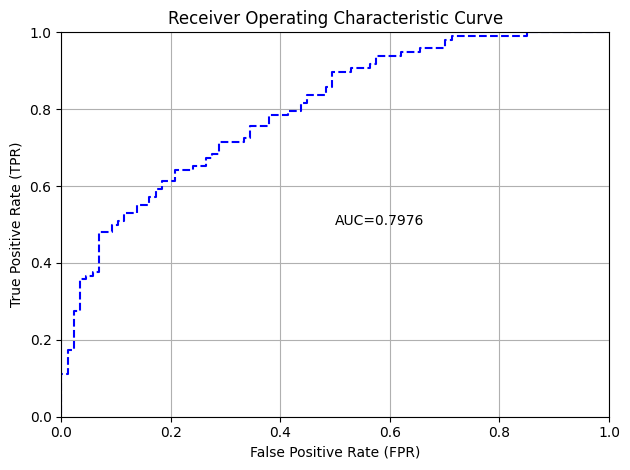

In [393]:
model.model_performance(valid=True).plot()
plt.show()

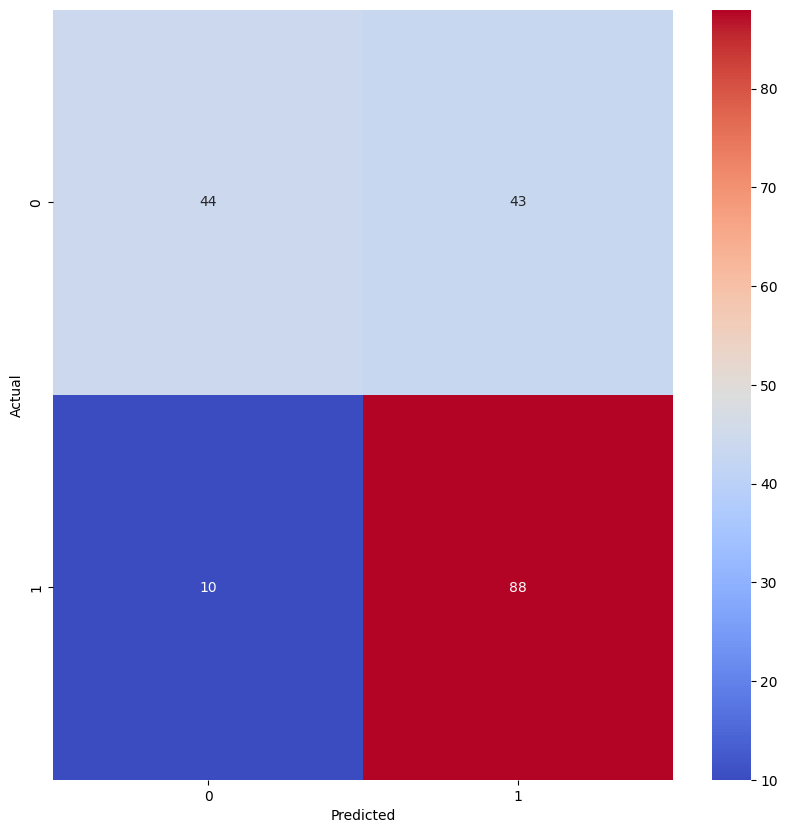

In [394]:
#show confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(pred_df['actual'], pred_df['predict'])
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, cmap='coolwarm')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [395]:
#auc score
from sklearn.metrics import roc_auc_score
roc_auc_score(pred_df['actual'], pred_df['predict'])



0.7018531550551256

In [396]:

#accuracy score
from sklearn.metrics import accuracy_score
accuracy_score(pred_df['actual'], pred_df['predict'])



0.7135135135135136

In [397]:

#precision score
from sklearn.metrics import precision_score
precision_score(pred_df['actual'], pred_df['predict'])



0.6717557251908397

In [398]:

#recall score
from sklearn.metrics import recall_score
recall_score(pred_df['actual'], pred_df['predict'])

 


0.8979591836734694

In [399]:
#f1 score
from sklearn.metrics import f1_score    
f1_score(pred_df['actual'], pred_df['predict'])


0.7685589519650655

In [400]:

#show classification report
from sklearn.metrics import classification_report
print(classification_report(pred_df['actual'], pred_df['predict']))


              precision    recall  f1-score   support

           0       0.81      0.51      0.62        87
           1       0.67      0.90      0.77        98

    accuracy                           0.71       185
   macro avg       0.74      0.70      0.70       185
weighted avg       0.74      0.71      0.70       185



# Model 2. Random Forest Classifier


drf Model Build progress: |

/usr/local/lib/python3.10/dist-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: early stopping is enabled but neither score_tree_interval or score_each_iteration are defined. Early stopping will not be reproducible!
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%


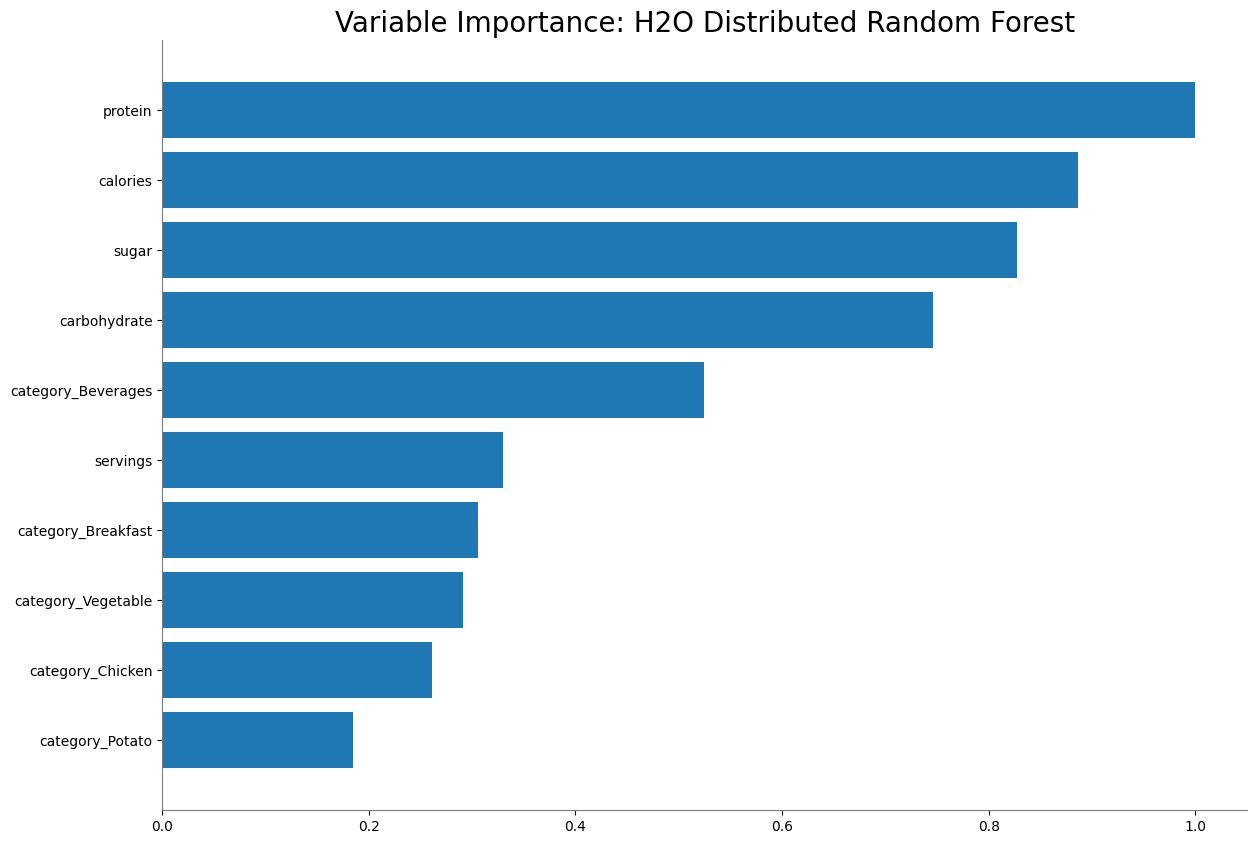

'/root/datacamp_professional/recipe_site_traffic_model_rf/DRF_model_python_1697564644145_15985'

<Figure size 640x480 with 0 Axes>

In [401]:
#repeat with random forest classifier
from h2o.estimators import H2ORandomForestEstimator
rf = H2ORandomForestEstimator(nfolds=100, seed=1, keep_cross_validation_predictions=True, 
                              stopping_rounds=50, stopping_tolerance=0.001, stopping_metric='auc')
rf.train(y='popularity', training_frame=train, validation_frame=test)
rf.varimp_plot()


 
#save model
h2o.save_model(model=rf, path='recipe_site_traffic_model_rf', force=True)

In [402]:
#load model
model = h2o.load_model('recipe_site_traffic_model_rf/DRF_model_python_1697485883597_17521')

In [403]:
#show model performance
model.model_performance()


ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.18781270982131665
RMSE: 0.43337363766306397
LogLoss: 0.5745500840208804
Mean Per-Class Error: 0.36536007449817204
AUC: 0.7733884596813133
AUCPR: 0.8406470975373317
Gini: 0.5467769193626266

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.25
       0    1    Error    Rate
-----  ---  ---  -------  -------------
0      82   184  0.6917   (184.0/266.0)
1      17   419  0.039    (17.0/436.0)
Total  99   603  0.2863   (201.0/702.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.25         0.806545  324
max f2                       0.228447     0.895206  333
max f0point5                 0.544084     0.772192  217
max accuracy                 0.421074     0.729345  265
max precision                1            1         0
max recall                   0.00893067   1         398
max specificity              1            1         0
max absolute_mcc             0.421074     0.402936  265
max min_per_class_accuracy   0.623988     0.690367  188
max mean_per_class_accuracy  0.544084     0.699326  217
max tns                      1            266       0
max fns                      1            429       0
max fps                      0.00375005   266       399
max tps                      0.00893067   436       398
max tnr                      1            1         0
max fnr                      1            0.983945  0
max fpr                      0.00375005   1         399
max tpr                      0.00893067   1         398

Gains/Lift Table: Avg response rate: 62.11 %, avg score: 61.37 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.011396                    0.999241           1.61009   1.61009            1                0.999905   1                           0.999905            0.0183486       0.0183486                  61.0092   61.0092            0.0183486
2        0.022792                    0.998106           1.61009   1.61009            1                0.998507   1                           0.999206            0.0183486       0.0366972                  61.0092   61.0092            0.0366972
3        0.031339                    0.997066           1.34174   1.53691            0.833333         0.997315   0.954545                    0.99869             0.0114679       0.0481651                  34.1743   53.6906            0.0444057
4        0.0413105                   0.995375           1.61009   1.55457            1                0.996349   0.965517                    0.998125            0.016055        0.0642202                  61.0092   55.4571            0.0604608
5        0.0512821                   0.993113           1.38008   1.52064            0.857143         0.994216   0.944444                    0.997365            0.0137615       0.0779817                  38.0079   52.0642            0.0704629
6        0.10114                     0.965939           1.47208   1.49671            0.914286         0.983558   0.929577                    0.990559            0.0733945       0.151376                   47.2084   49.6705            0.132579
7        0.150997                    0.928548           1.42608   1.47339            0.885714         0.942879   0.915094                    0.974815            0.0711009       0.222477                   42.6081   47.3386            0.188642
8        0.200855                    0.904838       

In [404]:

#show model performance on training data
model.model_performance(train=True)

#show model performance on test data
model.model_performance(valid=True)

#show model performance on cross validation data
model.model_performance(xval=True)

ModelMetricsBinomial: drf
** Reported on cross-validation data. **

MSE: 0.18467715118567146
RMSE: 0.4297407953472319
LogLoss: 0.5542153594694955
Mean Per-Class Error: 0.36829171552735046
AUC: 0.776889183969097
AUCPR: 0.8426666245933043
Gini: 0.553778367938194

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24447712063789373
       0    1    Error    Rate
-----  ---  ---  -------  -------------
0      78   188  0.7068   (188.0/266.0)
1      13   423  0.0298   (13.0/436.0)
Total  91   611  0.2863   (201.0/702.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.244477     0.808023  337
max f2                       0.167506     0.898994  358
max f0point5                 0.552314     0.777523  221
max accuracy                 0.495135     0.730769  246
max precision                0.99773      1         0
max recall                   0.0200615    1         396
max specificity              0.99773      1         0
max absolute_mcc             0.495135     0.415397  246
max min_per_class_accuracy   0.612961     0.699248  192
max mean_per_class_accuracy  0.552314     0.706431  221
max tns                      0.99773      266       0
max fns                      0.99773      432       0
max fps                      0.0122408    266       399
max tps                      0.0200615    436       396
max tnr                      0.99773      1         0
max fnr                      0.99773      0.990826  0
max fpr                      0.0122408    1         399
max tpr                      0.0200615    1         396

Gains/Lift Table: Avg response rate: 62.11 %, avg score: 61.46 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.011396                    0.996298           1.61009   1.61009            1                0.997256  1                           0.997256            0.0183486       0.0183486                  61.0092   61.0092            0.0183486
2        0.0213675                   0.99427            1.38008   1.50275            0.857143         0.995208  0.933333                    0.9963              0.0137615       0.0321101                  38.0079   50.2752            0.0283507
3        0.031339                    0.991462           1.38008   1.46372            0.857143         0.992291  0.909091                    0.995024            0.0137615       0.0458716                  38.0079   46.372             0.0383528
4        0.0413105                   0.987082           1.61009   1.49905            1                0.989311  0.931034                    0.993645            0.016055        0.0619266                  61.0092   49.9051            0.0544078
5        0.0512821                   0.977708           1.38008   1.47592            0.857143         0.981325  0.916667                    0.99125             0.0137615       0.0756881                  38.0079   47.5917            0.0644099
6        0.10114                     0.956546           1.51809   1.49671            0.942857         0.965994  0.929577                    0.9788              0.0756881       0.151376                   51.8087   49.6705            0.132579
7        0.152422                    0.931657           1.56537   1.51981            0.972222         0.943203  0.943925                    0.966823            0.0802752       0.231651                   56.5367   51.9806            0.209095
8        0.200855                    0

In [405]:


#use model to predict on test data
pred = model.predict(test)


drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [406]:

#show predictions
pred


predict        p0        p1
---------  --------  --------
        0  0.68022   0.31978
        1  0.406558  0.593442
        1  0.10564   0.89436
        1  0.144419  0.855581
        1  0.511217  0.488783
        1  0.281796  0.718204
        1  0.380444  0.619556
        0  0.752172  0.247828
        0  0.853891  0.146109
        1  0.473443  0.526557
[185 rows x 3 columns]

In [407]:

#show predictions as pandas dataframe
pred_df = pred.as_data_frame()
pred_df


predict        p0        p1
0          0  0.680220  0.319780
1          1  0.406558  0.593442
2          1  0.105640  0.894360
3          1  0.144419  0.855581
4          1  0.511217  0.488783
..       ...       ...       ...
180        0  0.552761  0.447239
181        1  0.509923  0.490077
182        1  0.024419  0.975581
183        1  0.136232  0.863768
184        1  0.013397  0.986603

[185 rows x 3 columns]

In [408]:
#show predictions as pandas dataframe with actual values
pred_df = pred.as_data_frame()
pred_df['actual'] = test['popularity'].as_data_frame()
pred_df


predict        p0        p1  actual
0          0  0.680220  0.319780       0
1          1  0.406558  0.593442       0
2          1  0.105640  0.894360       1
3          1  0.144419  0.855581       1
4          1  0.511217  0.488783       0
..       ...       ...       ...     ...
180        0  0.552761  0.447239       0
181        1  0.509923  0.490077       1
182        1  0.024419  0.975581       1
183        1  0.136232  0.863768       1
184        1  0.013397  0.986603       1

[185 rows x 4 columns]

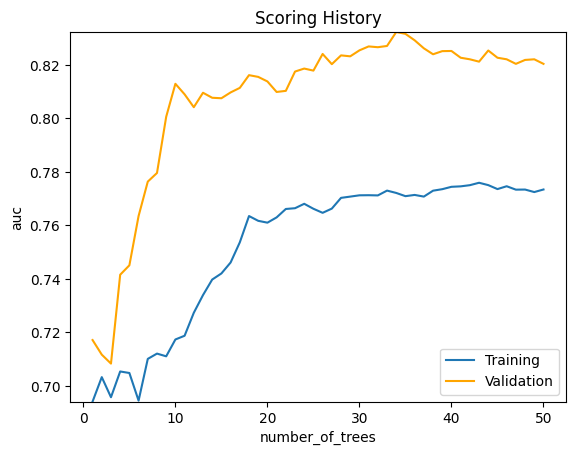

In [409]:

#plot auc
model.plot(metric='auc')


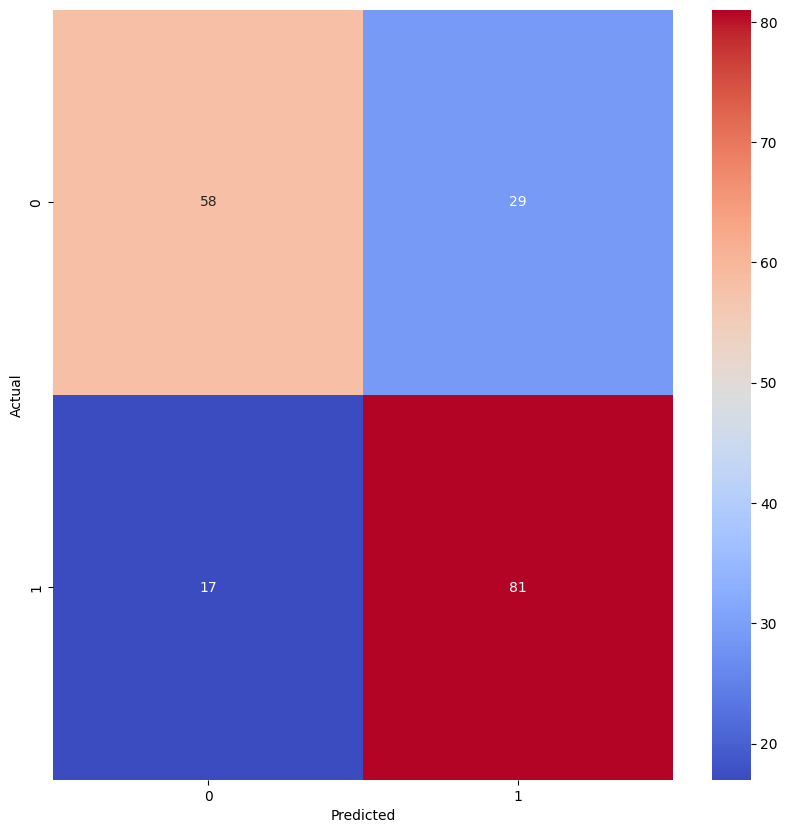

In [410]:

#show confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(pred_df['actual'], pred_df['predict'])
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, cmap='coolwarm')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [411]:

#auc score
from sklearn.metrics import roc_auc_score
roc_auc_score(pred_df['actual'], pred_df['predict'])


0.7465986394557823

In [412]:

#accuracy score
from sklearn.metrics import accuracy_score
accuracy_score(pred_df['actual'], pred_df['predict'])


0.7513513513513513

In [413]:

#precision score
from sklearn.metrics import precision_score
precision_score(pred_df['actual'], pred_df['predict'])


0.7363636363636363

In [414]:

#recall score
from sklearn.metrics import recall_score
recall_score(pred_df['actual'], pred_df['predict'])


0.826530612244898

In [415]:

#f1 score
from sklearn.metrics import f1_score
f1_score(pred_df['actual'], pred_df['predict'])


0.7788461538461539

In [416]:

#show classification report
from sklearn.metrics import classification_report   
print(classification_report(pred_df['actual'], pred_df['predict']))


              precision    recall  f1-score   support

           0       0.77      0.67      0.72        87
           1       0.74      0.83      0.78        98

    accuracy                           0.75       185
   macro avg       0.75      0.75      0.75       185
weighted avg       0.75      0.75      0.75       185



# Model 3. Gradient Boostin Machine

gbm Model Build progress: |

/usr/local/lib/python3.10/dist-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: early stopping is enabled but neither score_tree_interval or score_each_iteration are defined. Early stopping will not be reproducible!
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%


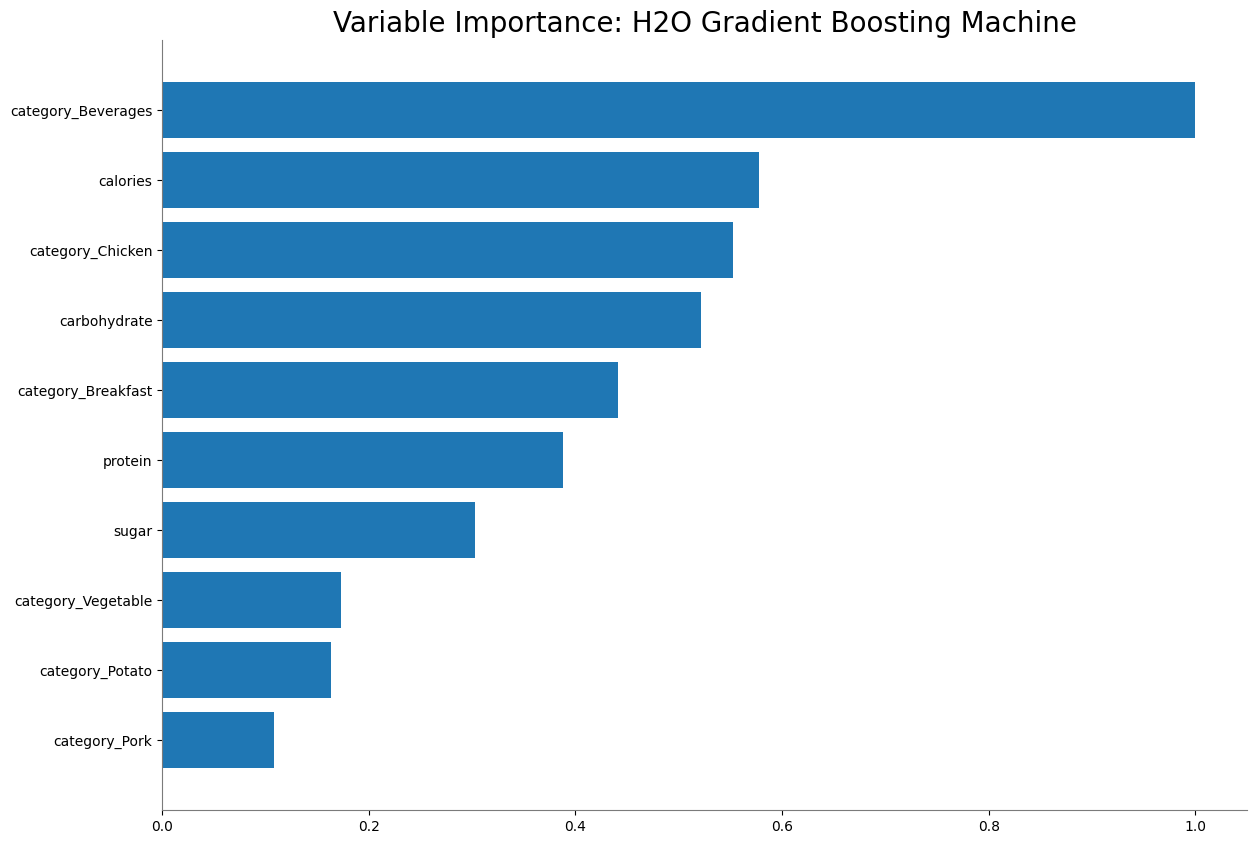

'/root/datacamp_professional/recipe_site_traffic_model_gbm/GBM_model_python_1697564644145_26288'

<Figure size 640x480 with 0 Axes>

In [417]:

#repeat with gradient boosting machine
from h2o.estimators import H2OGradientBoostingEstimator     
gbm = H2OGradientBoostingEstimator(nfolds=100, seed=1, keep_cross_validation_predictions=True, 
                                   stopping_rounds=50, stopping_tolerance=0.001, stopping_metric='auc')
gbm.train(y='popularity', training_frame=train, validation_frame=test)
gbm.varimp_plot()
 
#save model
h2o.save_model(model=gbm, path='recipe_site_traffic_model_gbm', force=True)


In [418]:

#load model
model = h2o.load_model('recipe_site_traffic_model_gbm/GBM_model_python_1697485883597_27824')

In [419]:
#show model performance
model.model_performance()
   
#show model performance on training data
model.model_performance(train=True)
 
#show model performance on test data
model.model_performance(valid=True)

#show model performance on cross validation data
model.model_performance(xval=True)




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.18669041796851654
RMSE: 0.4320768658103747
LogLoss: 0.5528473075022792
Mean Per-Class Error: 0.3763192384631303
AUC: 0.77017658825964
AUCPR: 0.8430090485879422
Gini: 0.5403531765192799

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2742947325293297
       0    1    Error    Rate
-----  ---  ---  -------  -------------
0      78   188  0.7068   (188.0/266.0)
1      20   416  0.0459   (20.0/436.0)
Total  98   604  0.2963   (208.0/702.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.274295     0.8       336
max f2                       0.128979     0.895087  374
max f0point5                 0.625019     0.768664  202
max accuracy                 0.490006     0.719373  264
max precision                0.991063     1         0
max recall                   0.0218627    1         399
max specificity              0.991063     1         0
max absolute_mcc             0.860922     0.387746  80
max min_per_class_accuracy   0.646023     0.68797   190
max mean_per_class_accuracy  0.625019     0.695411  202
max tns                      0.991063     266       0
max fns                      0.991063     435       0
max fps                      0.0310863    266       398
max tps                      0.0218627    436       399
max tnr                      0.991063     1         0
max fnr                      0.991063     0.997706  0
max fpr                      0.0310863    1         398
max tpr                      0.0218627    1         399

Gains/Lift Table: Avg response rate: 62.11 %, avg score: 62.31 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.011396                    0.973733           1.61009   1.61009            1                0.978935  1                           0.978935            0.0183486       0.0183486                  61.0092   61.0092            0.0183486
2        0.0213675                   0.970372           1.61009   1.61009            1                0.970898  1                           0.975185            0.016055        0.0344037                  61.0092   61.0092            0.0344037
3        0.031339                    0.968295           1.15007   1.46372            0.714286         0.968933  0.909091                    0.973195            0.0114679       0.0458716                  15.0066   46.372             0.0383528
4        0.0413105                   0.966838           1.61009   1.49905            1                0.967393  0.931034                    0.971795            0.016055        0.0619266                  61.0092   49.9051            0.0544078
5        0.0512821                   0.962092           1.38008   1.47592            0.857143         0.963859  0.916667                    0.970252            0.0137615       0.0756881                  38.0079   47.5917            0.0644099
6        0.10114                     0.949107           1.51809   1.49671            0.942857         0.956236  0.929577                    0.963342            0.0756881       0.151376                   51.8087   49.6705            0.132579
7        0.150997                    0.928959           1.47208   1.48858            0.914286         0.938143  0.924528                    0.955022            0.0733945       0.224771                   47.2084   48.8575            0.194695
8        0.200855                    0.90

In [420]:
#use model to predict on test data
pred = model.predict(test)
 
#show predictions
pred


#show predictions as pandas dataframe
pred_df = pred.as_data_frame()
pred_df
 
#show predictions as pandas dataframe with actual values
pred_df = pred.as_data_frame()
pred_df['actual'] = test['popularity'].as_data_frame()
pred_df


gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


predict        p0        p1  actual
0          0  0.699723  0.300277       0
1          0  0.450990  0.549010       0
2          1  0.053222  0.946778       1
3          1  0.059286  0.940714       1
4          0  0.484311  0.515689       0
..       ...       ...       ...     ...
180        0  0.551661  0.448339       0
181        1  0.373116  0.626884       1
182        1  0.026892  0.973108       1
183        1  0.250256  0.749744       1
184        1  0.064316  0.935684       1

[185 rows x 4 columns]

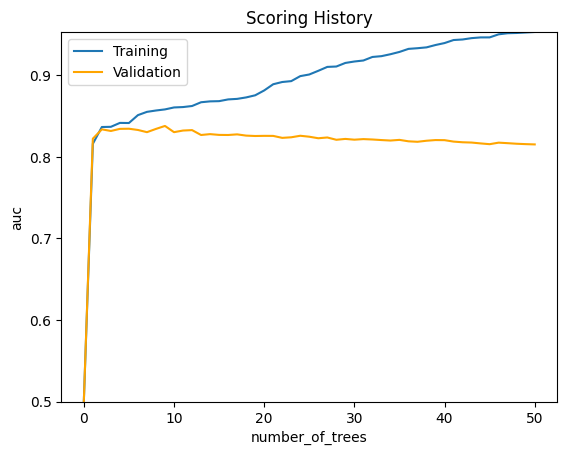

In [421]:

#plot auc
model.plot(metric='auc')